In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_075_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2629727, 828)
(2629727, 8)
validation
(311071, 828)
(311071, 8)
test
(385271, 828)
(385271, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/263 [..............................] - ETA: 5:55 - loss: 2.3742 - STD: 0.0896 - MAE: 0.2185

  5/263 [..............................] - ETA: 4s - loss: 2.1667 - STD: 0.0477 - MAE: 0.2183  

  9/263 [>.............................] - ETA: 3s - loss: 2.1475 - STD: 0.0437 - MAE: 0.2184

 13/263 [>.............................] - ETA: 3s - loss: 2.1272 - STD: 0.0357 - MAE: 0.2184

 17/263 [>.............................] - ETA: 3s - loss: 2.1165 - STD: 0.0321 - MAE: 0.2184

 21/263 [=>............................] - ETA: 3s - loss: 2.1101 - STD: 0.0303 - MAE: 0.2184

 25/263 [=>............................] - ETA: 3s - loss: 2.1042 - STD: 0.0277 - MAE: 0.2184

 29/263 [==>...........................] - ETA: 3s - loss: 2.0995 - STD: 0.0256 - MAE: 0.2184

 33/263 [==>...........................] - ETA: 3s - loss: 2.0957 - STD: 0.0243 - MAE: 0.2183

 37/263 [===>..........................] - ETA: 3s - loss: 2.0913 - STD: 0.0233 - MAE: 0.2183

 41/263 [===>..........................] - ETA: 3s - loss: 2.0862 - STD: 0.0226 - MAE: 0.2182

 45/263 [====>.........................] - ETA: 3s - loss: 2.0794 - STD: 0.0224 - MAE: 0.2180

 49/263 [====>.........................] - ETA: 3s - loss: 2.0702 - STD: 0.0231 - MAE: 0.2177

 53/263 [=====>........................] - ETA: 3s - loss: 2.0592 - STD: 0.0248 - MAE: 0.2172

 57/263 [=====>........................] - ETA: 3s - loss: 2.0468 - STD: 0.0271 - MAE: 0.2167

 61/263 [=====>........................] - ETA: 3s - loss: 2.0330 - STD: 0.0297 - MAE: 0.2160

 65/263 [======>.......................] - ETA: 3s - loss: 2.0176 - STD: 0.0323 - MAE: 0.2153

 69/263 [======>.......................] - ETA: 3s - loss: 2.0002 - STD: 0.0351 - MAE: 0.2144

 73/263 [=======>......................] - ETA: 2s - loss: 1.9819 - STD: 0.0380 - MAE: 0.2135

 77/263 [=======>......................] - ETA: 2s - loss: 1.9630 - STD: 0.0413 - MAE: 0.2124

 81/263 [========>.....................] - ETA: 2s - loss: 1.9437 - STD: 0.0448 - MAE: 0.2113

 85/263 [========>.....................] - ETA: 2s - loss: 1.9252 - STD: 0.0483 - MAE: 0.2101

 89/263 [=========>....................] - ETA: 2s - loss: 1.9076 - STD: 0.0517 - MAE: 0.2090

 93/263 [=========>....................] - ETA: 2s - loss: 1.8910 - STD: 0.0550 - MAE: 0.2079

 97/263 [==========>...................] - ETA: 3s - loss: 1.8749 - STD: 0.0580 - MAE: 0.2069

101/263 [==========>...................] - ETA: 3s - loss: 1.8597 - STD: 0.0609 - MAE: 0.2059

105/263 [==========>...................] - ETA: 3s - loss: 1.8449 - STD: 0.0635 - MAE: 0.2049

109/263 [===========>..................] - ETA: 3s - loss: 1.8309 - STD: 0.0661 - MAE: 0.2040

113/263 [===========>..................] - ETA: 3s - loss: 1.8176 - STD: 0.0686 - MAE: 0.2031

117/263 [============>.................] - ETA: 3s - loss: 1.8051 - STD: 0.0710 - MAE: 0.2023

121/263 [============>.................] - ETA: 3s - loss: 1.7931 - STD: 0.0732 - MAE: 0.2014

125/263 [=============>................] - ETA: 2s - loss: 1.7816 - STD: 0.0753 - MAE: 0.2007

129/263 [=============>................] - ETA: 2s - loss: 1.7706 - STD: 0.0773 - MAE: 0.1999

133/263 [==============>...............] - ETA: 2s - loss: 1.7599 - STD: 0.0793 - MAE: 0.1992

137/263 [==============>...............] - ETA: 2s - loss: 1.7497 - STD: 0.0811 - MAE: 0.1985

141/263 [===============>..............] - ETA: 2s - loss: 1.7398 - STD: 0.0829 - MAE: 0.1978

145/263 [===============>..............] - ETA: 2s - loss: 1.7304 - STD: 0.0846 - MAE: 0.1971

149/263 [===============>..............] - ETA: 2s - loss: 1.7214 - STD: 0.0863 - MAE: 0.1965

153/263 [================>.............] - ETA: 2s - loss: 1.7124 - STD: 0.0878 - MAE: 0.1959

157/263 [================>.............] - ETA: 2s - loss: 1.7036 - STD: 0.0894 - MAE: 0.1952

161/263 [=================>............] - ETA: 2s - loss: 1.6951 - STD: 0.0908 - MAE: 0.1946

165/263 [=================>............] - ETA: 1s - loss: 1.6869 - STD: 0.0923 - MAE: 0.1940

169/263 [==================>...........] - ETA: 1s - loss: 1.6789 - STD: 0.0937 - MAE: 0.1934

172/263 [==================>...........] - ETA: 1s - loss: 1.6730 - STD: 0.0947 - MAE: 0.1930

176/263 [===================>..........] - ETA: 1s - loss: 1.6653 - STD: 0.0961 - MAE: 0.1924

180/263 [===================>..........] - ETA: 1s - loss: 1.6580 - STD: 0.0974 - MAE: 0.1919

184/263 [===================>..........] - ETA: 1s - loss: 1.6506 - STD: 0.0987 - MAE: 0.1913

188/263 [====================>.........] - ETA: 1s - loss: 1.6437 - STD: 0.1000 - MAE: 0.1908

192/263 [====================>.........] - ETA: 1s - loss: 1.6371 - STD: 0.1012 - MAE: 0.1902

196/263 [=====================>........] - ETA: 1s - loss: 1.6305 - STD: 0.1024 - MAE: 0.1897

200/263 [=====================>........] - ETA: 1s - loss: 1.6239 - STD: 0.1036 - MAE: 0.1892

204/263 [======================>.......] - ETA: 1s - loss: 1.6175 - STD: 0.1047 - MAE: 0.1887

208/263 [======================>.......] - ETA: 1s - loss: 1.6112 - STD: 0.1058 - MAE: 0.1882

212/263 [=======================>......] - ETA: 0s - loss: 1.6053 - STD: 0.1069 - MAE: 0.1877

216/263 [=======================>......] - ETA: 0s - loss: 1.5993 - STD: 0.1080 - MAE: 0.1872

220/263 [========================>.....] - ETA: 0s - loss: 1.5936 - STD: 0.1090 - MAE: 0.1868

224/263 [========================>.....] - ETA: 0s - loss: 1.5881 - STD: 0.1101 - MAE: 0.1863

228/263 [=========================>....] - ETA: 0s - loss: 1.5827 - STD: 0.1111 - MAE: 0.1858

232/263 [=========================>....] - ETA: 0s - loss: 1.5774 - STD: 0.1120 - MAE: 0.1854

236/263 [=========================>....] - ETA: 0s - loss: 1.5722 - STD: 0.1130 - MAE: 0.1850

240/263 [==========================>...] - ETA: 0s - loss: 1.5670 - STD: 0.1139 - MAE: 0.1845

244/263 [==========================>...] - ETA: 0s - loss: 1.5618 - STD: 0.1148 - MAE: 0.1841

248/263 [===========================>..] - ETA: 0s - loss: 1.5568 - STD: 0.1157 - MAE: 0.1837

252/263 [===========================>..] - ETA: 0s - loss: 1.5517 - STD: 0.1166 - MAE: 0.1833

256/263 [============================>.] - ETA: 0s - loss: 1.5470 - STD: 0.1175 - MAE: 0.1829

260/263 [============================>.] - ETA: 0s - loss: 1.5424 - STD: 0.1183 - MAE: 0.1825

263/263 [==============================] - 7s 22ms/step - loss: 1.5389 - STD: 0.1189 - MAE: 0.1822 - val_loss: 1.2670 - val_STD: 0.1708 - val_MAE: 0.1587


Epoch 2/10000


  1/263 [..............................] - ETA: 12s - loss: 1.2414 - STD: 0.1711 - MAE: 0.1574

  4/263 [..............................] - ETA: 4s - loss: 1.2372 - STD: 0.1728 - MAE: 0.1567 

  8/263 [..............................] - ETA: 4s - loss: 1.2380 - STD: 0.1736 - MAE: 0.1564

 12/263 [>.............................] - ETA: 4s - loss: 1.2374 - STD: 0.1742 - MAE: 0.1561

 16/263 [>.............................] - ETA: 3s - loss: 1.2397 - STD: 0.1747 - MAE: 0.1560

 20/263 [=>............................] - ETA: 3s - loss: 1.2374 - STD: 0.1750 - MAE: 0.1558

 24/263 [=>............................] - ETA: 3s - loss: 1.2338 - STD: 0.1751 - MAE: 0.1556

 28/263 [==>...........................] - ETA: 3s - loss: 1.2305 - STD: 0.1753 - MAE: 0.1554

 32/263 [==>...........................] - ETA: 3s - loss: 1.2281 - STD: 0.1755 - MAE: 0.1552

 36/263 [===>..........................] - ETA: 3s - loss: 1.2260 - STD: 0.1757 - MAE: 0.1550

 40/263 [===>..........................] - ETA: 3s - loss: 1.2252 - STD: 0.1759 - MAE: 0.1549

 44/263 [====>.........................] - ETA: 3s - loss: 1.2249 - STD: 0.1762 - MAE: 0.1548

 48/263 [====>.........................] - ETA: 3s - loss: 1.2235 - STD: 0.1764 - MAE: 0.1547

 52/263 [====>.........................] - ETA: 3s - loss: 1.2221 - STD: 0.1766 - MAE: 0.1545

 55/263 [=====>........................] - ETA: 3s - loss: 1.2212 - STD: 0.1767 - MAE: 0.1544

 59/263 [=====>........................] - ETA: 3s - loss: 1.2197 - STD: 0.1769 - MAE: 0.1543

 63/263 [======>.......................] - ETA: 3s - loss: 1.2183 - STD: 0.1771 - MAE: 0.1542

 67/263 [======>.......................] - ETA: 3s - loss: 1.2171 - STD: 0.1774 - MAE: 0.1540

 71/263 [=======>......................] - ETA: 2s - loss: 1.2161 - STD: 0.1775 - MAE: 0.1539

 75/263 [=======>......................] - ETA: 2s - loss: 1.2160 - STD: 0.1776 - MAE: 0.1539

 79/263 [========>.....................] - ETA: 2s - loss: 1.2151 - STD: 0.1778 - MAE: 0.1538

 83/263 [========>.....................] - ETA: 2s - loss: 1.2147 - STD: 0.1780 - MAE: 0.1537

 87/263 [========>.....................] - ETA: 2s - loss: 1.2139 - STD: 0.1782 - MAE: 0.1536

 91/263 [=========>....................] - ETA: 2s - loss: 1.2134 - STD: 0.1783 - MAE: 0.1535

 95/263 [=========>....................] - ETA: 2s - loss: 1.2123 - STD: 0.1785 - MAE: 0.1534

 99/263 [==========>...................] - ETA: 2s - loss: 1.2119 - STD: 0.1787 - MAE: 0.1533

103/263 [==========>...................] - ETA: 2s - loss: 1.2111 - STD: 0.1788 - MAE: 0.1533

106/263 [===========>..................] - ETA: 2s - loss: 1.2108 - STD: 0.1789 - MAE: 0.1532

110/263 [===========>..................] - ETA: 2s - loss: 1.2098 - STD: 0.1790 - MAE: 0.1531

114/263 [============>.................] - ETA: 2s - loss: 1.2086 - STD: 0.1791 - MAE: 0.1530

118/263 [============>.................] - ETA: 2s - loss: 1.2071 - STD: 0.1793 - MAE: 0.1529

122/263 [============>.................] - ETA: 2s - loss: 1.2057 - STD: 0.1795 - MAE: 0.1527

126/263 [=============>................] - ETA: 2s - loss: 1.2045 - STD: 0.1797 - MAE: 0.1526

130/263 [=============>................] - ETA: 2s - loss: 1.2033 - STD: 0.1798 - MAE: 0.1525

134/263 [==============>...............] - ETA: 1s - loss: 1.2019 - STD: 0.1800 - MAE: 0.1524

138/263 [==============>...............] - ETA: 1s - loss: 1.2009 - STD: 0.1801 - MAE: 0.1523

142/263 [===============>..............] - ETA: 1s - loss: 1.1998 - STD: 0.1803 - MAE: 0.1522

146/263 [===============>..............] - ETA: 1s - loss: 1.1998 - STD: 0.1805 - MAE: 0.1521

150/263 [================>.............] - ETA: 1s - loss: 1.1997 - STD: 0.1806 - MAE: 0.1520

154/263 [================>.............] - ETA: 1s - loss: 1.1993 - STD: 0.1808 - MAE: 0.1519

158/263 [=================>............] - ETA: 1s - loss: 1.1984 - STD: 0.1809 - MAE: 0.1519

162/263 [=================>............] - ETA: 1s - loss: 1.1977 - STD: 0.1811 - MAE: 0.1518

166/263 [=================>............] - ETA: 1s - loss: 1.1966 - STD: 0.1812 - MAE: 0.1517

170/263 [==================>...........] - ETA: 1s - loss: 1.1956 - STD: 0.1813 - MAE: 0.1516

174/263 [==================>...........] - ETA: 1s - loss: 1.1946 - STD: 0.1815 - MAE: 0.1515

178/263 [===================>..........] - ETA: 1s - loss: 1.1934 - STD: 0.1816 - MAE: 0.1514

182/263 [===================>..........] - ETA: 1s - loss: 1.1922 - STD: 0.1817 - MAE: 0.1513

186/263 [====================>.........] - ETA: 1s - loss: 1.1912 - STD: 0.1818 - MAE: 0.1512

189/263 [====================>.........] - ETA: 1s - loss: 1.1903 - STD: 0.1819 - MAE: 0.1511

193/263 [=====================>........] - ETA: 1s - loss: 1.1892 - STD: 0.1821 - MAE: 0.1510

197/263 [=====================>........] - ETA: 1s - loss: 1.1884 - STD: 0.1822 - MAE: 0.1509

201/263 [=====================>........] - ETA: 0s - loss: 1.1872 - STD: 0.1824 - MAE: 0.1508

205/263 [======================>.......] - ETA: 0s - loss: 1.1862 - STD: 0.1825 - MAE: 0.1506

209/263 [======================>.......] - ETA: 0s - loss: 1.1853 - STD: 0.1827 - MAE: 0.1506

213/263 [=======================>......] - ETA: 0s - loss: 1.1842 - STD: 0.1828 - MAE: 0.1504

217/263 [=======================>......] - ETA: 0s - loss: 1.1836 - STD: 0.1829 - MAE: 0.1504

221/263 [========================>.....] - ETA: 0s - loss: 1.1827 - STD: 0.1831 - MAE: 0.1503

225/263 [========================>.....] - ETA: 0s - loss: 1.1821 - STD: 0.1832 - MAE: 0.1502

229/263 [=========================>....] - ETA: 0s - loss: 1.1814 - STD: 0.1833 - MAE: 0.1501

233/263 [=========================>....] - ETA: 0s - loss: 1.1805 - STD: 0.1834 - MAE: 0.1500

237/263 [==========================>...] - ETA: 0s - loss: 1.1800 - STD: 0.1836 - MAE: 0.1499

241/263 [==========================>...] - ETA: 0s - loss: 1.1795 - STD: 0.1837 - MAE: 0.1499

245/263 [==========================>...] - ETA: 0s - loss: 1.1788 - STD: 0.1838 - MAE: 0.1498

249/263 [===========================>..] - ETA: 0s - loss: 1.1780 - STD: 0.1839 - MAE: 0.1497

253/263 [===========================>..] - ETA: 0s - loss: 1.1773 - STD: 0.1841 - MAE: 0.1496

257/263 [============================>.] - ETA: 0s - loss: 1.1764 - STD: 0.1842 - MAE: 0.1496

261/263 [============================>.] - ETA: 0s - loss: 1.1757 - STD: 0.1843 - MAE: 0.1495

263/263 [==============================] - 5s 17ms/step - loss: 1.1754 - STD: 0.1843 - MAE: 0.1494 - val_loss: 1.1668 - val_STD: 0.1909 - val_MAE: 0.1474


Epoch 3/10000


  1/263 [..............................] - ETA: 11s - loss: 1.1285 - STD: 0.1898 - MAE: 0.1451

  4/263 [..............................] - ETA: 4s - loss: 1.1280 - STD: 0.1910 - MAE: 0.1446 

  8/263 [..............................] - ETA: 4s - loss: 1.1269 - STD: 0.1909 - MAE: 0.1447

 12/263 [>.............................] - ETA: 3s - loss: 1.1275 - STD: 0.1911 - MAE: 0.1446

 16/263 [>.............................] - ETA: 3s - loss: 1.1236 - STD: 0.1913 - MAE: 0.1443

 20/263 [=>............................] - ETA: 3s - loss: 1.1203 - STD: 0.1915 - MAE: 0.1440

 24/263 [=>............................] - ETA: 3s - loss: 1.1184 - STD: 0.1918 - MAE: 0.1438

 28/263 [==>...........................] - ETA: 3s - loss: 1.1158 - STD: 0.1920 - MAE: 0.1436

 32/263 [==>...........................] - ETA: 3s - loss: 1.1126 - STD: 0.1922 - MAE: 0.1433

 36/263 [===>..........................] - ETA: 3s - loss: 1.1113 - STD: 0.1924 - MAE: 0.1432

 40/263 [===>..........................] - ETA: 3s - loss: 1.1103 - STD: 0.1926 - MAE: 0.1431

 44/263 [====>.........................] - ETA: 3s - loss: 1.1103 - STD: 0.1927 - MAE: 0.1430

 48/263 [====>.........................] - ETA: 3s - loss: 1.1103 - STD: 0.1928 - MAE: 0.1430

 52/263 [====>.........................] - ETA: 3s - loss: 1.1102 - STD: 0.1930 - MAE: 0.1429

 56/263 [=====>........................] - ETA: 3s - loss: 1.1096 - STD: 0.1930 - MAE: 0.1429

 60/263 [=====>........................] - ETA: 3s - loss: 1.1101 - STD: 0.1931 - MAE: 0.1428

 64/263 [======>.......................] - ETA: 3s - loss: 1.1089 - STD: 0.1932 - MAE: 0.1427

 68/263 [======>.......................] - ETA: 3s - loss: 1.1077 - STD: 0.1934 - MAE: 0.1426

 72/263 [=======>......................] - ETA: 2s - loss: 1.1070 - STD: 0.1934 - MAE: 0.1425

 76/263 [=======>......................] - ETA: 2s - loss: 1.1060 - STD: 0.1935 - MAE: 0.1424

 80/263 [========>.....................] - ETA: 2s - loss: 1.1049 - STD: 0.1936 - MAE: 0.1424

 84/263 [========>.....................] - ETA: 2s - loss: 1.1040 - STD: 0.1937 - MAE: 0.1423

 88/263 [=========>....................] - ETA: 2s - loss: 1.1041 - STD: 0.1938 - MAE: 0.1422

 92/263 [=========>....................] - ETA: 2s - loss: 1.1039 - STD: 0.1939 - MAE: 0.1422

 96/263 [=========>....................] - ETA: 2s - loss: 1.1040 - STD: 0.1940 - MAE: 0.1421

100/263 [==========>...................] - ETA: 2s - loss: 1.1038 - STD: 0.1941 - MAE: 0.1421

104/263 [==========>...................] - ETA: 2s - loss: 1.1035 - STD: 0.1942 - MAE: 0.1421

108/263 [===========>..................] - ETA: 2s - loss: 1.1033 - STD: 0.1943 - MAE: 0.1420

112/263 [===========>..................] - ETA: 2s - loss: 1.1029 - STD: 0.1943 - MAE: 0.1420

116/263 [============>.................] - ETA: 2s - loss: 1.1025 - STD: 0.1944 - MAE: 0.1419

120/263 [============>.................] - ETA: 2s - loss: 1.1022 - STD: 0.1944 - MAE: 0.1419

124/263 [=============>................] - ETA: 2s - loss: 1.1019 - STD: 0.1944 - MAE: 0.1419

128/263 [=============>................] - ETA: 2s - loss: 1.1022 - STD: 0.1945 - MAE: 0.1419

132/263 [==============>...............] - ETA: 2s - loss: 1.1019 - STD: 0.1946 - MAE: 0.1418

136/263 [==============>...............] - ETA: 1s - loss: 1.1012 - STD: 0.1947 - MAE: 0.1418

140/263 [==============>...............] - ETA: 1s - loss: 1.1004 - STD: 0.1947 - MAE: 0.1417

144/263 [===============>..............] - ETA: 1s - loss: 1.0995 - STD: 0.1948 - MAE: 0.1416

148/263 [===============>..............] - ETA: 1s - loss: 1.0987 - STD: 0.1948 - MAE: 0.1415

152/263 [================>.............] - ETA: 1s - loss: 1.0979 - STD: 0.1949 - MAE: 0.1415

156/263 [================>.............] - ETA: 1s - loss: 1.0971 - STD: 0.1950 - MAE: 0.1414

160/263 [=================>............] - ETA: 1s - loss: 1.0964 - STD: 0.1951 - MAE: 0.1413

163/263 [=================>............] - ETA: 1s - loss: 1.0958 - STD: 0.1951 - MAE: 0.1413

167/263 [==================>...........] - ETA: 1s - loss: 1.0951 - STD: 0.1952 - MAE: 0.1412

171/263 [==================>...........] - ETA: 1s - loss: 1.0941 - STD: 0.1953 - MAE: 0.1411

175/263 [==================>...........] - ETA: 1s - loss: 1.0936 - STD: 0.1954 - MAE: 0.1411

179/263 [===================>..........] - ETA: 1s - loss: 1.0930 - STD: 0.1955 - MAE: 0.1410

183/263 [===================>..........] - ETA: 1s - loss: 1.0923 - STD: 0.1956 - MAE: 0.1409

187/263 [====================>.........] - ETA: 1s - loss: 1.0920 - STD: 0.1956 - MAE: 0.1409

191/263 [====================>.........] - ETA: 1s - loss: 1.0914 - STD: 0.1957 - MAE: 0.1408

195/263 [=====================>........] - ETA: 1s - loss: 1.0907 - STD: 0.1958 - MAE: 0.1407

199/263 [=====================>........] - ETA: 0s - loss: 1.0900 - STD: 0.1959 - MAE: 0.1407

203/263 [======================>.......] - ETA: 0s - loss: 1.0899 - STD: 0.1960 - MAE: 0.1406

207/263 [======================>.......] - ETA: 0s - loss: 1.0897 - STD: 0.1960 - MAE: 0.1406

211/263 [=======================>......] - ETA: 0s - loss: 1.0893 - STD: 0.1961 - MAE: 0.1406

215/263 [=======================>......] - ETA: 0s - loss: 1.0885 - STD: 0.1962 - MAE: 0.1405

219/263 [=======================>......] - ETA: 0s - loss: 1.0879 - STD: 0.1962 - MAE: 0.1404

223/263 [========================>.....] - ETA: 0s - loss: 1.0872 - STD: 0.1963 - MAE: 0.1404

227/263 [========================>.....] - ETA: 0s - loss: 1.0867 - STD: 0.1964 - MAE: 0.1403

231/263 [=========================>....] - ETA: 0s - loss: 1.0862 - STD: 0.1965 - MAE: 0.1402

235/263 [=========================>....] - ETA: 0s - loss: 1.0857 - STD: 0.1965 - MAE: 0.1402

239/263 [==========================>...] - ETA: 0s - loss: 1.0853 - STD: 0.1966 - MAE: 0.1401

243/263 [==========================>...] - ETA: 0s - loss: 1.0847 - STD: 0.1967 - MAE: 0.1401

247/263 [===========================>..] - ETA: 0s - loss: 1.0843 - STD: 0.1967 - MAE: 0.1400

251/263 [===========================>..] - ETA: 0s - loss: 1.0840 - STD: 0.1968 - MAE: 0.1400

255/263 [============================>.] - ETA: 0s - loss: 1.0838 - STD: 0.1969 - MAE: 0.1399

259/263 [============================>.] - ETA: 0s - loss: 1.0832 - STD: 0.1970 - MAE: 0.1399

263/263 [==============================] - ETA: 0s - loss: 1.0825 - STD: 0.1970 - MAE: 0.1398

263/263 [==============================] - 5s 17ms/step - loss: 1.0825 - STD: 0.1970 - MAE: 0.1398 - val_loss: 1.1189 - val_STD: 0.2022 - val_MAE: 0.1413


Epoch 4/10000


  1/263 [..............................] - ETA: 13s - loss: 1.0277 - STD: 0.2014 - MAE: 0.1347

  5/263 [..............................] - ETA: 3s - loss: 1.0347 - STD: 0.2020 - MAE: 0.1353 

  9/263 [>.............................] - ETA: 4s - loss: 1.0366 - STD: 0.2018 - MAE: 0.1354

 12/263 [>.............................] - ETA: 4s - loss: 1.0357 - STD: 0.2016 - MAE: 0.1355

 16/263 [>.............................] - ETA: 4s - loss: 1.0368 - STD: 0.2016 - MAE: 0.1355

 20/263 [=>............................] - ETA: 3s - loss: 1.0374 - STD: 0.2016 - MAE: 0.1355

 24/263 [=>............................] - ETA: 3s - loss: 1.0385 - STD: 0.2019 - MAE: 0.1355

 28/263 [==>...........................] - ETA: 3s - loss: 1.0415 - STD: 0.2021 - MAE: 0.1356

 32/263 [==>...........................] - ETA: 3s - loss: 1.0416 - STD: 0.2022 - MAE: 0.1355

 36/263 [===>..........................] - ETA: 3s - loss: 1.0415 - STD: 0.2021 - MAE: 0.1356

 40/263 [===>..........................] - ETA: 3s - loss: 1.0407 - STD: 0.2022 - MAE: 0.1355

 44/263 [====>.........................] - ETA: 3s - loss: 1.0410 - STD: 0.2023 - MAE: 0.1355

 48/263 [====>.........................] - ETA: 3s - loss: 1.0414 - STD: 0.2024 - MAE: 0.1355

 52/263 [====>.........................] - ETA: 3s - loss: 1.0404 - STD: 0.2024 - MAE: 0.1354

 56/263 [=====>........................] - ETA: 3s - loss: 1.0397 - STD: 0.2025 - MAE: 0.1353

 60/263 [=====>........................] - ETA: 3s - loss: 1.0396 - STD: 0.2025 - MAE: 0.1353

 64/263 [======>.......................] - ETA: 3s - loss: 1.0389 - STD: 0.2026 - MAE: 0.1352

 68/263 [======>.......................] - ETA: 3s - loss: 1.0393 - STD: 0.2026 - MAE: 0.1352

 72/263 [=======>......................] - ETA: 2s - loss: 1.0384 - STD: 0.2027 - MAE: 0.1352

 76/263 [=======>......................] - ETA: 2s - loss: 1.0377 - STD: 0.2027 - MAE: 0.1351

 80/263 [========>.....................] - ETA: 2s - loss: 1.0363 - STD: 0.2028 - MAE: 0.1350

 84/263 [========>.....................] - ETA: 2s - loss: 1.0354 - STD: 0.2028 - MAE: 0.1349

 88/263 [=========>....................] - ETA: 2s - loss: 1.0346 - STD: 0.2029 - MAE: 0.1349

 92/263 [=========>....................] - ETA: 2s - loss: 1.0339 - STD: 0.2030 - MAE: 0.1348

 96/263 [=========>....................] - ETA: 2s - loss: 1.0334 - STD: 0.2031 - MAE: 0.1347

100/263 [==========>...................] - ETA: 2s - loss: 1.0329 - STD: 0.2032 - MAE: 0.1346

104/263 [==========>...................] - ETA: 2s - loss: 1.0322 - STD: 0.2033 - MAE: 0.1346

108/263 [===========>..................] - ETA: 2s - loss: 1.0316 - STD: 0.2033 - MAE: 0.1345

112/263 [===========>..................] - ETA: 2s - loss: 1.0313 - STD: 0.2034 - MAE: 0.1345

116/263 [============>.................] - ETA: 2s - loss: 1.0313 - STD: 0.2035 - MAE: 0.1345

120/263 [============>.................] - ETA: 2s - loss: 1.0310 - STD: 0.2035 - MAE: 0.1344

124/263 [=============>................] - ETA: 2s - loss: 1.0305 - STD: 0.2036 - MAE: 0.1344

128/263 [=============>................] - ETA: 2s - loss: 1.0301 - STD: 0.2036 - MAE: 0.1343

132/263 [==============>...............] - ETA: 2s - loss: 1.0297 - STD: 0.2037 - MAE: 0.1343

136/263 [==============>...............] - ETA: 1s - loss: 1.0291 - STD: 0.2037 - MAE: 0.1342

140/263 [==============>...............] - ETA: 1s - loss: 1.0289 - STD: 0.2038 - MAE: 0.1342

144/263 [===============>..............] - ETA: 1s - loss: 1.0292 - STD: 0.2038 - MAE: 0.1342

148/263 [===============>..............] - ETA: 1s - loss: 1.0294 - STD: 0.2039 - MAE: 0.1342

152/263 [================>.............] - ETA: 1s - loss: 1.0292 - STD: 0.2040 - MAE: 0.1341

156/263 [================>.............] - ETA: 1s - loss: 1.0287 - STD: 0.2040 - MAE: 0.1341

160/263 [=================>............] - ETA: 1s - loss: 1.0285 - STD: 0.2041 - MAE: 0.1341

164/263 [=================>............] - ETA: 1s - loss: 1.0283 - STD: 0.2042 - MAE: 0.1340

168/263 [==================>...........] - ETA: 1s - loss: 1.0277 - STD: 0.2042 - MAE: 0.1340

172/263 [==================>...........] - ETA: 1s - loss: 1.0271 - STD: 0.2043 - MAE: 0.1339

176/263 [===================>..........] - ETA: 1s - loss: 1.0265 - STD: 0.2043 - MAE: 0.1339

180/263 [===================>..........] - ETA: 1s - loss: 1.0262 - STD: 0.2044 - MAE: 0.1338

184/263 [===================>..........] - ETA: 1s - loss: 1.0258 - STD: 0.2044 - MAE: 0.1338

188/263 [====================>.........] - ETA: 1s - loss: 1.0259 - STD: 0.2045 - MAE: 0.1337

192/263 [====================>.........] - ETA: 1s - loss: 1.0256 - STD: 0.2045 - MAE: 0.1337

196/263 [=====================>........] - ETA: 1s - loss: 1.0253 - STD: 0.2046 - MAE: 0.1337

200/263 [=====================>........] - ETA: 0s - loss: 1.0252 - STD: 0.2046 - MAE: 0.1337

204/263 [======================>.......] - ETA: 0s - loss: 1.0249 - STD: 0.2047 - MAE: 0.1336

208/263 [======================>.......] - ETA: 0s - loss: 1.0244 - STD: 0.2047 - MAE: 0.1336

212/263 [=======================>......] - ETA: 0s - loss: 1.0241 - STD: 0.2048 - MAE: 0.1335

216/263 [=======================>......] - ETA: 0s - loss: 1.0234 - STD: 0.2048 - MAE: 0.1335

220/263 [========================>.....] - ETA: 0s - loss: 1.0229 - STD: 0.2049 - MAE: 0.1334

224/263 [========================>.....] - ETA: 0s - loss: 1.0224 - STD: 0.2049 - MAE: 0.1334

227/263 [========================>.....] - ETA: 0s - loss: 1.0221 - STD: 0.2050 - MAE: 0.1333

231/263 [=========================>....] - ETA: 0s - loss: 1.0218 - STD: 0.2050 - MAE: 0.1333

235/263 [=========================>....] - ETA: 0s - loss: 1.0216 - STD: 0.2051 - MAE: 0.1332

239/263 [==========================>...] - ETA: 0s - loss: 1.0217 - STD: 0.2052 - MAE: 0.1332

243/263 [==========================>...] - ETA: 0s - loss: 1.0213 - STD: 0.2052 - MAE: 0.1332

247/263 [===========================>..] - ETA: 0s - loss: 1.0209 - STD: 0.2053 - MAE: 0.1331

251/263 [===========================>..] - ETA: 0s - loss: 1.0203 - STD: 0.2053 - MAE: 0.1331

255/263 [============================>.] - ETA: 0s - loss: 1.0198 - STD: 0.2054 - MAE: 0.1330

259/263 [============================>.] - ETA: 0s - loss: 1.0193 - STD: 0.2054 - MAE: 0.1330

263/263 [==============================] - ETA: 0s - loss: 1.0187 - STD: 0.2055 - MAE: 0.1329

263/263 [==============================] - 5s 17ms/step - loss: 1.0187 - STD: 0.2055 - MAE: 0.1329 - val_loss: 1.0908 - val_STD: 0.2087 - val_MAE: 0.1372


Epoch 5/10000


  1/263 [..............................] - ETA: 12s - loss: 0.9617 - STD: 0.2097 - MAE: 0.1276

  4/263 [..............................] - ETA: 4s - loss: 0.9835 - STD: 0.2093 - MAE: 0.1294 

  8/263 [..............................] - ETA: 4s - loss: 0.9867 - STD: 0.2094 - MAE: 0.1294

 12/263 [>.............................] - ETA: 3s - loss: 0.9913 - STD: 0.2094 - MAE: 0.1297

 15/263 [>.............................] - ETA: 3s - loss: 0.9940 - STD: 0.2092 - MAE: 0.1299

 19/263 [=>............................] - ETA: 3s - loss: 0.9931 - STD: 0.2091 - MAE: 0.1299

 23/263 [=>............................] - ETA: 3s - loss: 0.9916 - STD: 0.2091 - MAE: 0.1299

 27/263 [==>...........................] - ETA: 3s - loss: 0.9912 - STD: 0.2092 - MAE: 0.1298

 31/263 [==>...........................] - ETA: 3s - loss: 0.9899 - STD: 0.2094 - MAE: 0.1296

 35/263 [==>...........................] - ETA: 3s - loss: 0.9899 - STD: 0.2095 - MAE: 0.1296

 39/263 [===>..........................] - ETA: 3s - loss: 0.9905 - STD: 0.2096 - MAE: 0.1296

 43/263 [===>..........................] - ETA: 3s - loss: 0.9918 - STD: 0.2096 - MAE: 0.1297

 46/263 [====>.........................] - ETA: 3s - loss: 0.9914 - STD: 0.2096 - MAE: 0.1296

 49/263 [====>.........................] - ETA: 3s - loss: 0.9909 - STD: 0.2096 - MAE: 0.1296

 53/263 [=====>........................] - ETA: 3s - loss: 0.9902 - STD: 0.2097 - MAE: 0.1296

 57/263 [=====>........................] - ETA: 3s - loss: 0.9890 - STD: 0.2097 - MAE: 0.1295

 61/263 [=====>........................] - ETA: 3s - loss: 0.9909 - STD: 0.2097 - MAE: 0.1296

 64/263 [======>.......................] - ETA: 3s - loss: 0.9906 - STD: 0.2098 - MAE: 0.1296

 67/263 [======>.......................] - ETA: 3s - loss: 0.9907 - STD: 0.2098 - MAE: 0.1295

 70/263 [======>.......................] - ETA: 3s - loss: 0.9912 - STD: 0.2098 - MAE: 0.1296

 73/263 [=======>......................] - ETA: 3s - loss: 0.9911 - STD: 0.2098 - MAE: 0.1296

 77/263 [=======>......................] - ETA: 3s - loss: 0.9901 - STD: 0.2099 - MAE: 0.1295

 81/263 [========>.....................] - ETA: 2s - loss: 0.9898 - STD: 0.2099 - MAE: 0.1294

 85/263 [========>.....................] - ETA: 2s - loss: 0.9887 - STD: 0.2099 - MAE: 0.1294

 89/263 [=========>....................] - ETA: 2s - loss: 0.9882 - STD: 0.2100 - MAE: 0.1293

 93/263 [=========>....................] - ETA: 2s - loss: 0.9877 - STD: 0.2100 - MAE: 0.1293

 97/263 [==========>...................] - ETA: 2s - loss: 0.9870 - STD: 0.2100 - MAE: 0.1292

100/263 [==========>...................] - ETA: 2s - loss: 0.9868 - STD: 0.2101 - MAE: 0.1292

103/263 [==========>...................] - ETA: 2s - loss: 0.9868 - STD: 0.2101 - MAE: 0.1292

107/263 [===========>..................] - ETA: 2s - loss: 0.9863 - STD: 0.2102 - MAE: 0.1291

111/263 [===========>..................] - ETA: 2s - loss: 0.9856 - STD: 0.2102 - MAE: 0.1291

115/263 [============>.................] - ETA: 2s - loss: 0.9859 - STD: 0.2102 - MAE: 0.1291

119/263 [============>.................] - ETA: 2s - loss: 0.9859 - STD: 0.2103 - MAE: 0.1290

123/263 [=============>................] - ETA: 2s - loss: 0.9865 - STD: 0.2104 - MAE: 0.1291

127/263 [=============>................] - ETA: 2s - loss: 0.9866 - STD: 0.2104 - MAE: 0.1290

131/263 [=============>................] - ETA: 2s - loss: 0.9862 - STD: 0.2105 - MAE: 0.1290

135/263 [==============>...............] - ETA: 2s - loss: 0.9856 - STD: 0.2105 - MAE: 0.1289

139/263 [==============>...............] - ETA: 1s - loss: 0.9851 - STD: 0.2105 - MAE: 0.1289

143/263 [===============>..............] - ETA: 1s - loss: 0.9845 - STD: 0.2106 - MAE: 0.1288

147/263 [===============>..............] - ETA: 1s - loss: 0.9839 - STD: 0.2106 - MAE: 0.1288

151/263 [================>.............] - ETA: 1s - loss: 0.9836 - STD: 0.2106 - MAE: 0.1288

155/263 [================>.............] - ETA: 1s - loss: 0.9833 - STD: 0.2107 - MAE: 0.1287

159/263 [=================>............] - ETA: 1s - loss: 0.9827 - STD: 0.2107 - MAE: 0.1287

162/263 [=================>............] - ETA: 1s - loss: 0.9824 - STD: 0.2107 - MAE: 0.1287

166/263 [=================>............] - ETA: 1s - loss: 0.9818 - STD: 0.2108 - MAE: 0.1286

170/263 [==================>...........] - ETA: 1s - loss: 0.9813 - STD: 0.2108 - MAE: 0.1286

174/263 [==================>...........] - ETA: 1s - loss: 0.9807 - STD: 0.2109 - MAE: 0.1285

177/263 [===================>..........] - ETA: 1s - loss: 0.9803 - STD: 0.2109 - MAE: 0.1285

180/263 [===================>..........] - ETA: 1s - loss: 0.9799 - STD: 0.2110 - MAE: 0.1284

183/263 [===================>..........] - ETA: 1s - loss: 0.9796 - STD: 0.2110 - MAE: 0.1284

186/263 [====================>.........] - ETA: 1s - loss: 0.9792 - STD: 0.2110 - MAE: 0.1283

190/263 [====================>.........] - ETA: 1s - loss: 0.9787 - STD: 0.2111 - MAE: 0.1283

194/263 [=====================>........] - ETA: 1s - loss: 0.9784 - STD: 0.2111 - MAE: 0.1283

198/263 [=====================>........] - ETA: 1s - loss: 0.9781 - STD: 0.2112 - MAE: 0.1282

202/263 [======================>.......] - ETA: 0s - loss: 0.9780 - STD: 0.2112 - MAE: 0.1282

206/263 [======================>.......] - ETA: 0s - loss: 0.9785 - STD: 0.2113 - MAE: 0.1282

210/263 [======================>.......] - ETA: 0s - loss: 0.9785 - STD: 0.2113 - MAE: 0.1282

213/263 [=======================>......] - ETA: 0s - loss: 0.9784 - STD: 0.2113 - MAE: 0.1282

216/263 [=======================>......] - ETA: 0s - loss: 0.9782 - STD: 0.2114 - MAE: 0.1281

220/263 [========================>.....] - ETA: 0s - loss: 0.9778 - STD: 0.2114 - MAE: 0.1281

224/263 [========================>.....] - ETA: 0s - loss: 0.9773 - STD: 0.2114 - MAE: 0.1281

227/263 [========================>.....] - ETA: 0s - loss: 0.9771 - STD: 0.2114 - MAE: 0.1280

230/263 [=========================>....] - ETA: 0s - loss: 0.9768 - STD: 0.2115 - MAE: 0.1280

233/263 [=========================>....] - ETA: 0s - loss: 0.9763 - STD: 0.2115 - MAE: 0.1280

236/263 [=========================>....] - ETA: 0s - loss: 0.9760 - STD: 0.2115 - MAE: 0.1279

240/263 [==========================>...] - ETA: 0s - loss: 0.9756 - STD: 0.2116 - MAE: 0.1279

244/263 [==========================>...] - ETA: 0s - loss: 0.9754 - STD: 0.2116 - MAE: 0.1279

248/263 [===========================>..] - ETA: 0s - loss: 0.9754 - STD: 0.2117 - MAE: 0.1279

252/263 [===========================>..] - ETA: 0s - loss: 0.9755 - STD: 0.2117 - MAE: 0.1278

256/263 [============================>.] - ETA: 0s - loss: 0.9753 - STD: 0.2117 - MAE: 0.1278

260/263 [============================>.] - ETA: 0s - loss: 0.9750 - STD: 0.2118 - MAE: 0.1278

263/263 [==============================] - 5s 18ms/step - loss: 0.9747 - STD: 0.2118 - MAE: 0.1278 - val_loss: 1.1215 - val_STD: 0.2139 - val_MAE: 0.1370


Epoch 6/10000


  1/263 [..............................] - ETA: 10s - loss: 0.9679 - STD: 0.2139 - MAE: 0.1266

  5/263 [..............................] - ETA: 4s - loss: 0.9535 - STD: 0.2143 - MAE: 0.1255 

  9/263 [>.............................] - ETA: 3s - loss: 0.9516 - STD: 0.2142 - MAE: 0.1254

 12/263 [>.............................] - ETA: 3s - loss: 0.9506 - STD: 0.2143 - MAE: 0.1253

 16/263 [>.............................] - ETA: 3s - loss: 0.9487 - STD: 0.2141 - MAE: 0.1253

 20/263 [=>............................] - ETA: 3s - loss: 0.9483 - STD: 0.2141 - MAE: 0.1252

 24/263 [=>............................] - ETA: 3s - loss: 0.9470 - STD: 0.2143 - MAE: 0.1251

 28/263 [==>...........................] - ETA: 3s - loss: 0.9458 - STD: 0.2144 - MAE: 0.1250

 31/263 [==>...........................] - ETA: 3s - loss: 0.9444 - STD: 0.2144 - MAE: 0.1248

 34/263 [==>...........................] - ETA: 3s - loss: 0.9447 - STD: 0.2145 - MAE: 0.1248

 38/263 [===>..........................] - ETA: 3s - loss: 0.9467 - STD: 0.2146 - MAE: 0.1249

 42/263 [===>..........................] - ETA: 3s - loss: 0.9489 - STD: 0.2147 - MAE: 0.1250

 45/263 [====>.........................] - ETA: 3s - loss: 0.9492 - STD: 0.2147 - MAE: 0.1250

 48/263 [====>.........................] - ETA: 3s - loss: 0.9508 - STD: 0.2148 - MAE: 0.1251

 51/263 [====>.........................] - ETA: 3s - loss: 0.9539 - STD: 0.2148 - MAE: 0.1253

 54/263 [=====>........................] - ETA: 3s - loss: 0.9537 - STD: 0.2147 - MAE: 0.1253

 58/263 [=====>........................] - ETA: 3s - loss: 0.9527 - STD: 0.2147 - MAE: 0.1253

 62/263 [======>.......................] - ETA: 3s - loss: 0.9519 - STD: 0.2147 - MAE: 0.1252

 66/263 [======>.......................] - ETA: 3s - loss: 0.9515 - STD: 0.2147 - MAE: 0.1252

 70/263 [======>.......................] - ETA: 3s - loss: 0.9514 - STD: 0.2147 - MAE: 0.1251

 74/263 [=======>......................] - ETA: 3s - loss: 0.9502 - STD: 0.2148 - MAE: 0.1251

 77/263 [=======>......................] - ETA: 3s - loss: 0.9503 - STD: 0.2148 - MAE: 0.1250

 80/263 [========>.....................] - ETA: 3s - loss: 0.9499 - STD: 0.2149 - MAE: 0.1250

 84/263 [========>.....................] - ETA: 2s - loss: 0.9501 - STD: 0.2149 - MAE: 0.1250

 88/263 [=========>....................] - ETA: 2s - loss: 0.9500 - STD: 0.2150 - MAE: 0.1250

 92/263 [=========>....................] - ETA: 2s - loss: 0.9496 - STD: 0.2150 - MAE: 0.1249

 96/263 [=========>....................] - ETA: 2s - loss: 0.9493 - STD: 0.2151 - MAE: 0.1249

 99/263 [==========>...................] - ETA: 2s - loss: 0.9489 - STD: 0.2151 - MAE: 0.1248

102/263 [==========>...................] - ETA: 2s - loss: 0.9489 - STD: 0.2151 - MAE: 0.1248

105/263 [==========>...................] - ETA: 2s - loss: 0.9485 - STD: 0.2151 - MAE: 0.1248

108/263 [===========>..................] - ETA: 2s - loss: 0.9490 - STD: 0.2152 - MAE: 0.1248

112/263 [===========>..................] - ETA: 2s - loss: 0.9490 - STD: 0.2152 - MAE: 0.1248

116/263 [============>.................] - ETA: 2s - loss: 0.9495 - STD: 0.2153 - MAE: 0.1248

120/263 [============>.................] - ETA: 2s - loss: 0.9501 - STD: 0.2153 - MAE: 0.1248

124/263 [=============>................] - ETA: 2s - loss: 0.9505 - STD: 0.2153 - MAE: 0.1248

128/263 [=============>................] - ETA: 2s - loss: 0.9505 - STD: 0.2153 - MAE: 0.1248

132/263 [==============>...............] - ETA: 2s - loss: 0.9504 - STD: 0.2153 - MAE: 0.1248

135/263 [==============>...............] - ETA: 2s - loss: 0.9504 - STD: 0.2153 - MAE: 0.1248

138/263 [==============>...............] - ETA: 2s - loss: 0.9503 - STD: 0.2153 - MAE: 0.1248

142/263 [===============>..............] - ETA: 1s - loss: 0.9499 - STD: 0.2153 - MAE: 0.1248

145/263 [===============>..............] - ETA: 1s - loss: 0.9497 - STD: 0.2153 - MAE: 0.1248

149/263 [===============>..............] - ETA: 1s - loss: 0.9493 - STD: 0.2153 - MAE: 0.1247

153/263 [================>.............] - ETA: 1s - loss: 0.9489 - STD: 0.2153 - MAE: 0.1247

157/263 [================>.............] - ETA: 1s - loss: 0.9486 - STD: 0.2154 - MAE: 0.1247

161/263 [=================>............] - ETA: 1s - loss: 0.9483 - STD: 0.2154 - MAE: 0.1246

165/263 [=================>............] - ETA: 1s - loss: 0.9477 - STD: 0.2155 - MAE: 0.1246

169/263 [==================>...........] - ETA: 1s - loss: 0.9473 - STD: 0.2155 - MAE: 0.1245

173/263 [==================>...........] - ETA: 1s - loss: 0.9470 - STD: 0.2156 - MAE: 0.1245

176/263 [===================>..........] - ETA: 1s - loss: 0.9468 - STD: 0.2156 - MAE: 0.1245

180/263 [===================>..........] - ETA: 1s - loss: 0.9463 - STD: 0.2156 - MAE: 0.1244

184/263 [===================>..........] - ETA: 1s - loss: 0.9461 - STD: 0.2156 - MAE: 0.1244

188/263 [====================>.........] - ETA: 1s - loss: 0.9459 - STD: 0.2157 - MAE: 0.1244

192/263 [====================>.........] - ETA: 1s - loss: 0.9464 - STD: 0.2157 - MAE: 0.1244

196/263 [=====================>........] - ETA: 1s - loss: 0.9465 - STD: 0.2157 - MAE: 0.1244

200/263 [=====================>........] - ETA: 1s - loss: 0.9468 - STD: 0.2157 - MAE: 0.1244

204/263 [======================>.......] - ETA: 0s - loss: 0.9470 - STD: 0.2158 - MAE: 0.1244

208/263 [======================>.......] - ETA: 0s - loss: 0.9470 - STD: 0.2158 - MAE: 0.1244

212/263 [=======================>......] - ETA: 0s - loss: 0.9468 - STD: 0.2159 - MAE: 0.1243

215/263 [=======================>......] - ETA: 0s - loss: 0.9467 - STD: 0.2159 - MAE: 0.1243

219/263 [=======================>......] - ETA: 0s - loss: 0.9465 - STD: 0.2159 - MAE: 0.1243

223/263 [========================>.....] - ETA: 0s - loss: 0.9466 - STD: 0.2159 - MAE: 0.1243

227/263 [========================>.....] - ETA: 0s - loss: 0.9464 - STD: 0.2160 - MAE: 0.1243

230/263 [=========================>....] - ETA: 0s - loss: 0.9462 - STD: 0.2160 - MAE: 0.1243

233/263 [=========================>....] - ETA: 0s - loss: 0.9460 - STD: 0.2160 - MAE: 0.1243

236/263 [=========================>....] - ETA: 0s - loss: 0.9459 - STD: 0.2160 - MAE: 0.1242

239/263 [==========================>...] - ETA: 0s - loss: 0.9457 - STD: 0.2160 - MAE: 0.1242

242/263 [==========================>...] - ETA: 0s - loss: 0.9456 - STD: 0.2160 - MAE: 0.1242

246/263 [===========================>..] - ETA: 0s - loss: 0.9452 - STD: 0.2160 - MAE: 0.1242

250/263 [===========================>..] - ETA: 0s - loss: 0.9449 - STD: 0.2160 - MAE: 0.1241

254/263 [===========================>..] - ETA: 0s - loss: 0.9446 - STD: 0.2161 - MAE: 0.1241

258/263 [============================>.] - ETA: 0s - loss: 0.9442 - STD: 0.2161 - MAE: 0.1241

262/263 [============================>.] - ETA: 0s - loss: 0.9439 - STD: 0.2161 - MAE: 0.1240

263/263 [==============================] - 5s 18ms/step - loss: 0.9438 - STD: 0.2162 - MAE: 0.1240 - val_loss: 1.1200 - val_STD: 0.2146 - val_MAE: 0.1362


Epoch 7/10000


  1/263 [..............................] - ETA: 11s - loss: 0.9190 - STD: 0.2185 - MAE: 0.1215

  4/263 [..............................] - ETA: 4s - loss: 0.9136 - STD: 0.2181 - MAE: 0.1215 

  8/263 [..............................] - ETA: 4s - loss: 0.9144 - STD: 0.2180 - MAE: 0.1214

 12/263 [>.............................] - ETA: 4s - loss: 0.9163 - STD: 0.2181 - MAE: 0.1215

 15/263 [>.............................] - ETA: 4s - loss: 0.9170 - STD: 0.2184 - MAE: 0.1215

 19/263 [=>............................] - ETA: 3s - loss: 0.9175 - STD: 0.2186 - MAE: 0.1214

 23/263 [=>............................] - ETA: 3s - loss: 0.9183 - STD: 0.2186 - MAE: 0.1215

 27/263 [==>...........................] - ETA: 3s - loss: 0.9175 - STD: 0.2186 - MAE: 0.1214

 31/263 [==>...........................] - ETA: 3s - loss: 0.9178 - STD: 0.2186 - MAE: 0.1214

 35/263 [==>...........................] - ETA: 3s - loss: 0.9190 - STD: 0.2187 - MAE: 0.1214

 39/263 [===>..........................] - ETA: 3s - loss: 0.9210 - STD: 0.2188 - MAE: 0.1215

 43/263 [===>..........................] - ETA: 3s - loss: 0.9231 - STD: 0.2187 - MAE: 0.1217

 47/263 [====>.........................] - ETA: 3s - loss: 0.9242 - STD: 0.2188 - MAE: 0.1217

 51/263 [====>.........................] - ETA: 3s - loss: 0.9246 - STD: 0.2187 - MAE: 0.1218

 55/263 [=====>........................] - ETA: 3s - loss: 0.9252 - STD: 0.2187 - MAE: 0.1218

 59/263 [=====>........................] - ETA: 3s - loss: 0.9268 - STD: 0.2187 - MAE: 0.1219

 63/263 [======>.......................] - ETA: 3s - loss: 0.9269 - STD: 0.2187 - MAE: 0.1219

 67/263 [======>.......................] - ETA: 3s - loss: 0.9267 - STD: 0.2187 - MAE: 0.1219

 71/263 [=======>......................] - ETA: 3s - loss: 0.9265 - STD: 0.2186 - MAE: 0.1219

 75/263 [=======>......................] - ETA: 2s - loss: 0.9255 - STD: 0.2186 - MAE: 0.1219

 79/263 [========>.....................] - ETA: 2s - loss: 0.9257 - STD: 0.2186 - MAE: 0.1219

 83/263 [========>.....................] - ETA: 2s - loss: 0.9249 - STD: 0.2186 - MAE: 0.1218

 87/263 [========>.....................] - ETA: 2s - loss: 0.9243 - STD: 0.2186 - MAE: 0.1218

 91/263 [=========>....................] - ETA: 2s - loss: 0.9242 - STD: 0.2187 - MAE: 0.1217

 95/263 [=========>....................] - ETA: 2s - loss: 0.9241 - STD: 0.2187 - MAE: 0.1217

 99/263 [==========>...................] - ETA: 2s - loss: 0.9239 - STD: 0.2187 - MAE: 0.1217

103/263 [==========>...................] - ETA: 2s - loss: 0.9239 - STD: 0.2187 - MAE: 0.1217

107/263 [===========>..................] - ETA: 2s - loss: 0.9236 - STD: 0.2188 - MAE: 0.1217

111/263 [===========>..................] - ETA: 2s - loss: 0.9232 - STD: 0.2188 - MAE: 0.1216

115/263 [============>.................] - ETA: 2s - loss: 0.9225 - STD: 0.2189 - MAE: 0.1216

119/263 [============>.................] - ETA: 2s - loss: 0.9222 - STD: 0.2189 - MAE: 0.1215

122/263 [============>.................] - ETA: 2s - loss: 0.9221 - STD: 0.2189 - MAE: 0.1215

126/263 [=============>................] - ETA: 2s - loss: 0.9221 - STD: 0.2189 - MAE: 0.1215

130/263 [=============>................] - ETA: 2s - loss: 0.9222 - STD: 0.2190 - MAE: 0.1215

134/263 [==============>...............] - ETA: 2s - loss: 0.9221 - STD: 0.2190 - MAE: 0.1215

138/263 [==============>...............] - ETA: 1s - loss: 0.9218 - STD: 0.2190 - MAE: 0.1214

142/263 [===============>..............] - ETA: 1s - loss: 0.9215 - STD: 0.2190 - MAE: 0.1214

146/263 [===============>..............] - ETA: 1s - loss: 0.9212 - STD: 0.2191 - MAE: 0.1214

150/263 [================>.............] - ETA: 1s - loss: 0.9209 - STD: 0.2191 - MAE: 0.1213

154/263 [================>.............] - ETA: 1s - loss: 0.9206 - STD: 0.2191 - MAE: 0.1213

158/263 [=================>............] - ETA: 1s - loss: 0.9202 - STD: 0.2192 - MAE: 0.1213

162/263 [=================>............] - ETA: 1s - loss: 0.9197 - STD: 0.2192 - MAE: 0.1212

165/263 [=================>............] - ETA: 1s - loss: 0.9195 - STD: 0.2192 - MAE: 0.1212

169/263 [==================>...........] - ETA: 1s - loss: 0.9189 - STD: 0.2193 - MAE: 0.1211

173/263 [==================>...........] - ETA: 1s - loss: 0.9184 - STD: 0.2193 - MAE: 0.1211

176/263 [===================>..........] - ETA: 1s - loss: 0.9179 - STD: 0.2193 - MAE: 0.1210

179/263 [===================>..........] - ETA: 1s - loss: 0.9178 - STD: 0.2194 - MAE: 0.1210

183/263 [===================>..........] - ETA: 1s - loss: 0.9175 - STD: 0.2194 - MAE: 0.1210

187/263 [====================>.........] - ETA: 1s - loss: 0.9173 - STD: 0.2194 - MAE: 0.1210

191/263 [====================>.........] - ETA: 1s - loss: 0.9172 - STD: 0.2194 - MAE: 0.1210

195/263 [=====================>........] - ETA: 1s - loss: 0.9171 - STD: 0.2195 - MAE: 0.1209

199/263 [=====================>........] - ETA: 1s - loss: 0.9175 - STD: 0.2196 - MAE: 0.1209

202/263 [======================>.......] - ETA: 0s - loss: 0.9177 - STD: 0.2196 - MAE: 0.1209

205/263 [======================>.......] - ETA: 0s - loss: 0.9180 - STD: 0.2196 - MAE: 0.1209

208/263 [======================>.......] - ETA: 0s - loss: 0.9181 - STD: 0.2196 - MAE: 0.1209

211/263 [=======================>......] - ETA: 0s - loss: 0.9180 - STD: 0.2196 - MAE: 0.1209

214/263 [=======================>......] - ETA: 0s - loss: 0.9181 - STD: 0.2196 - MAE: 0.1209

217/263 [=======================>......] - ETA: 0s - loss: 0.9181 - STD: 0.2196 - MAE: 0.1209

220/263 [========================>.....] - ETA: 0s - loss: 0.9181 - STD: 0.2196 - MAE: 0.1209

223/263 [========================>.....] - ETA: 0s - loss: 0.9179 - STD: 0.2197 - MAE: 0.1209

226/263 [========================>.....] - ETA: 0s - loss: 0.9177 - STD: 0.2197 - MAE: 0.1209

230/263 [=========================>....] - ETA: 0s - loss: 0.9174 - STD: 0.2197 - MAE: 0.1209

233/263 [=========================>....] - ETA: 0s - loss: 0.9173 - STD: 0.2197 - MAE: 0.1209

236/263 [=========================>....] - ETA: 0s - loss: 0.9171 - STD: 0.2197 - MAE: 0.1208

239/263 [==========================>...] - ETA: 0s - loss: 0.9168 - STD: 0.2198 - MAE: 0.1208

242/263 [==========================>...] - ETA: 0s - loss: 0.9166 - STD: 0.2198 - MAE: 0.1208

245/263 [==========================>...] - ETA: 0s - loss: 0.9163 - STD: 0.2198 - MAE: 0.1208

248/263 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2198 - MAE: 0.1207

251/263 [===========================>..] - ETA: 0s - loss: 0.9157 - STD: 0.2198 - MAE: 0.1207

254/263 [===========================>..] - ETA: 0s - loss: 0.9154 - STD: 0.2199 - MAE: 0.1207

257/263 [============================>.] - ETA: 0s - loss: 0.9151 - STD: 0.2199 - MAE: 0.1207

260/263 [============================>.] - ETA: 0s - loss: 0.9150 - STD: 0.2199 - MAE: 0.1206

263/263 [==============================] - 5s 18ms/step - loss: 0.9149 - STD: 0.2199 - MAE: 0.1206 - val_loss: 1.1011 - val_STD: 0.2166 - val_MAE: 0.1347


Epoch 8/10000


  1/263 [..............................] - ETA: 12s - loss: 0.8847 - STD: 0.2204 - MAE: 0.1185

  4/263 [..............................] - ETA: 4s - loss: 0.8837 - STD: 0.2216 - MAE: 0.1178 

  8/263 [..............................] - ETA: 4s - loss: 0.8881 - STD: 0.2217 - MAE: 0.1180

 12/263 [>.............................] - ETA: 4s - loss: 0.8908 - STD: 0.2218 - MAE: 0.1181

 16/263 [>.............................] - ETA: 3s - loss: 0.8974 - STD: 0.2220 - MAE: 0.1184

 20/263 [=>............................] - ETA: 3s - loss: 0.8971 - STD: 0.2222 - MAE: 0.1183

 24/263 [=>............................] - ETA: 3s - loss: 0.8962 - STD: 0.2222 - MAE: 0.1183

 28/263 [==>...........................] - ETA: 3s - loss: 0.8946 - STD: 0.2221 - MAE: 0.1183

 32/263 [==>...........................] - ETA: 3s - loss: 0.8940 - STD: 0.2220 - MAE: 0.1183

 36/263 [===>..........................] - ETA: 3s - loss: 0.8929 - STD: 0.2220 - MAE: 0.1183

 40/263 [===>..........................] - ETA: 3s - loss: 0.8943 - STD: 0.2220 - MAE: 0.1184

 44/263 [====>.........................] - ETA: 3s - loss: 0.8944 - STD: 0.2221 - MAE: 0.1184

 48/263 [====>.........................] - ETA: 3s - loss: 0.8943 - STD: 0.2221 - MAE: 0.1184

 52/263 [====>.........................] - ETA: 3s - loss: 0.8942 - STD: 0.2222 - MAE: 0.1183

 56/263 [=====>........................] - ETA: 3s - loss: 0.8935 - STD: 0.2222 - MAE: 0.1183

 60/263 [=====>........................] - ETA: 3s - loss: 0.8935 - STD: 0.2223 - MAE: 0.1183

 64/263 [======>.......................] - ETA: 3s - loss: 0.8935 - STD: 0.2223 - MAE: 0.1182

 68/263 [======>.......................] - ETA: 3s - loss: 0.8936 - STD: 0.2223 - MAE: 0.1182

 72/263 [=======>......................] - ETA: 3s - loss: 0.8932 - STD: 0.2223 - MAE: 0.1182

 75/263 [=======>......................] - ETA: 2s - loss: 0.8933 - STD: 0.2224 - MAE: 0.1182

 79/263 [========>.....................] - ETA: 2s - loss: 0.8939 - STD: 0.2224 - MAE: 0.1182

 83/263 [========>.....................] - ETA: 2s - loss: 0.8950 - STD: 0.2224 - MAE: 0.1183

 87/263 [========>.....................] - ETA: 2s - loss: 0.8958 - STD: 0.2224 - MAE: 0.1184

 91/263 [=========>....................] - ETA: 2s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1184

 95/263 [=========>....................] - ETA: 2s - loss: 0.8971 - STD: 0.2225 - MAE: 0.1184

 99/263 [==========>...................] - ETA: 2s - loss: 0.8972 - STD: 0.2225 - MAE: 0.1184

103/263 [==========>...................] - ETA: 2s - loss: 0.8973 - STD: 0.2225 - MAE: 0.1184

107/263 [===========>..................] - ETA: 2s - loss: 0.8975 - STD: 0.2225 - MAE: 0.1184

111/263 [===========>..................] - ETA: 2s - loss: 0.8976 - STD: 0.2225 - MAE: 0.1184

115/263 [============>.................] - ETA: 2s - loss: 0.8977 - STD: 0.2225 - MAE: 0.1184

119/263 [============>.................] - ETA: 2s - loss: 0.8982 - STD: 0.2226 - MAE: 0.1184

123/263 [=============>................] - ETA: 2s - loss: 0.8981 - STD: 0.2226 - MAE: 0.1184

127/263 [=============>................] - ETA: 2s - loss: 0.8979 - STD: 0.2226 - MAE: 0.1184

131/263 [=============>................] - ETA: 2s - loss: 0.8974 - STD: 0.2226 - MAE: 0.1184

135/263 [==============>...............] - ETA: 2s - loss: 0.8972 - STD: 0.2226 - MAE: 0.1184

139/263 [==============>...............] - ETA: 1s - loss: 0.8968 - STD: 0.2226 - MAE: 0.1183

143/263 [===============>..............] - ETA: 1s - loss: 0.8965 - STD: 0.2226 - MAE: 0.1183

147/263 [===============>..............] - ETA: 1s - loss: 0.8962 - STD: 0.2226 - MAE: 0.1183

151/263 [================>.............] - ETA: 1s - loss: 0.8962 - STD: 0.2226 - MAE: 0.1183

155/263 [================>.............] - ETA: 1s - loss: 0.8960 - STD: 0.2227 - MAE: 0.1182

159/263 [=================>............] - ETA: 1s - loss: 0.8957 - STD: 0.2227 - MAE: 0.1182

163/263 [=================>............] - ETA: 1s - loss: 0.8959 - STD: 0.2227 - MAE: 0.1182

167/263 [==================>...........] - ETA: 1s - loss: 0.8955 - STD: 0.2227 - MAE: 0.1182

171/263 [==================>...........] - ETA: 1s - loss: 0.8951 - STD: 0.2227 - MAE: 0.1182

174/263 [==================>...........] - ETA: 1s - loss: 0.8951 - STD: 0.2228 - MAE: 0.1182

177/263 [===================>..........] - ETA: 1s - loss: 0.8948 - STD: 0.2228 - MAE: 0.1181

180/263 [===================>..........] - ETA: 1s - loss: 0.8948 - STD: 0.2228 - MAE: 0.1181

183/263 [===================>..........] - ETA: 1s - loss: 0.8945 - STD: 0.2228 - MAE: 0.1181

186/263 [====================>.........] - ETA: 1s - loss: 0.8942 - STD: 0.2228 - MAE: 0.1181

189/263 [====================>.........] - ETA: 1s - loss: 0.8940 - STD: 0.2228 - MAE: 0.1181

192/263 [====================>.........] - ETA: 1s - loss: 0.8939 - STD: 0.2229 - MAE: 0.1180

195/263 [=====================>........] - ETA: 1s - loss: 0.8937 - STD: 0.2229 - MAE: 0.1180

198/263 [=====================>........] - ETA: 1s - loss: 0.8935 - STD: 0.2229 - MAE: 0.1180

201/263 [=====================>........] - ETA: 0s - loss: 0.8941 - STD: 0.2229 - MAE: 0.1180

204/263 [======================>.......] - ETA: 0s - loss: 0.8941 - STD: 0.2229 - MAE: 0.1180

207/263 [======================>.......] - ETA: 0s - loss: 0.8946 - STD: 0.2230 - MAE: 0.1180

210/263 [======================>.......] - ETA: 0s - loss: 0.8952 - STD: 0.2230 - MAE: 0.1181

213/263 [=======================>......] - ETA: 0s - loss: 0.8954 - STD: 0.2230 - MAE: 0.1181

217/263 [=======================>......] - ETA: 0s - loss: 0.8958 - STD: 0.2230 - MAE: 0.1181

221/263 [========================>.....] - ETA: 0s - loss: 0.8961 - STD: 0.2230 - MAE: 0.1181

225/263 [========================>.....] - ETA: 0s - loss: 0.8961 - STD: 0.2230 - MAE: 0.1181

229/263 [=========================>....] - ETA: 0s - loss: 0.8961 - STD: 0.2230 - MAE: 0.1181

233/263 [=========================>....] - ETA: 0s - loss: 0.8960 - STD: 0.2230 - MAE: 0.1181

237/263 [==========================>...] - ETA: 0s - loss: 0.8959 - STD: 0.2230 - MAE: 0.1181

241/263 [==========================>...] - ETA: 0s - loss: 0.8956 - STD: 0.2230 - MAE: 0.1181

245/263 [==========================>...] - ETA: 0s - loss: 0.8952 - STD: 0.2230 - MAE: 0.1181

249/263 [===========================>..] - ETA: 0s - loss: 0.8948 - STD: 0.2230 - MAE: 0.1180

253/263 [===========================>..] - ETA: 0s - loss: 0.8945 - STD: 0.2230 - MAE: 0.1180

257/263 [============================>.] - ETA: 0s - loss: 0.8943 - STD: 0.2230 - MAE: 0.1180

261/263 [============================>.] - ETA: 0s - loss: 0.8940 - STD: 0.2231 - MAE: 0.1179

263/263 [==============================] - 5s 18ms/step - loss: 0.8939 - STD: 0.2231 - MAE: 0.1179 - val_loss: 1.1416 - val_STD: 0.2172 - val_MAE: 0.1366


Epoch 9/10000


  1/263 [..............................] - ETA: 11s - loss: 0.8927 - STD: 0.2239 - MAE: 0.1174

  4/263 [..............................] - ETA: 4s - loss: 0.8749 - STD: 0.2249 - MAE: 0.1159 

  8/263 [..............................] - ETA: 4s - loss: 0.8749 - STD: 0.2249 - MAE: 0.1159

 12/263 [>.............................] - ETA: 4s - loss: 0.8797 - STD: 0.2246 - MAE: 0.1163

 15/263 [>.............................] - ETA: 4s - loss: 0.8810 - STD: 0.2247 - MAE: 0.1163

 19/263 [=>............................] - ETA: 4s - loss: 0.8800 - STD: 0.2250 - MAE: 0.1162

 23/263 [=>............................] - ETA: 3s - loss: 0.8782 - STD: 0.2247 - MAE: 0.1162

 27/263 [==>...........................] - ETA: 3s - loss: 0.8760 - STD: 0.2247 - MAE: 0.1161

 31/263 [==>...........................] - ETA: 3s - loss: 0.8754 - STD: 0.2247 - MAE: 0.1160

 35/263 [==>...........................] - ETA: 3s - loss: 0.8737 - STD: 0.2247 - MAE: 0.1160

 39/263 [===>..........................] - ETA: 3s - loss: 0.8730 - STD: 0.2247 - MAE: 0.1159

 43/263 [===>..........................] - ETA: 3s - loss: 0.8749 - STD: 0.2247 - MAE: 0.1160

 47/263 [====>.........................] - ETA: 3s - loss: 0.8761 - STD: 0.2248 - MAE: 0.1161

 51/263 [====>.........................] - ETA: 3s - loss: 0.8765 - STD: 0.2249 - MAE: 0.1161

 55/263 [=====>........................] - ETA: 3s - loss: 0.8758 - STD: 0.2249 - MAE: 0.1160

 59/263 [=====>........................] - ETA: 3s - loss: 0.8750 - STD: 0.2250 - MAE: 0.1159

 62/263 [======>.......................] - ETA: 3s - loss: 0.8745 - STD: 0.2250 - MAE: 0.1159

 65/263 [======>.......................] - ETA: 3s - loss: 0.8743 - STD: 0.2251 - MAE: 0.1158

 68/263 [======>.......................] - ETA: 3s - loss: 0.8737 - STD: 0.2250 - MAE: 0.1158

 72/263 [=======>......................] - ETA: 3s - loss: 0.8734 - STD: 0.2250 - MAE: 0.1158

 76/263 [=======>......................] - ETA: 3s - loss: 0.8731 - STD: 0.2250 - MAE: 0.1158

 79/263 [========>.....................] - ETA: 3s - loss: 0.8732 - STD: 0.2250 - MAE: 0.1158

 83/263 [========>.....................] - ETA: 2s - loss: 0.8730 - STD: 0.2251 - MAE: 0.1157

 87/263 [========>.....................] - ETA: 2s - loss: 0.8726 - STD: 0.2252 - MAE: 0.1157

 91/263 [=========>....................] - ETA: 2s - loss: 0.8725 - STD: 0.2252 - MAE: 0.1157

 95/263 [=========>....................] - ETA: 2s - loss: 0.8722 - STD: 0.2252 - MAE: 0.1156

 99/263 [==========>...................] - ETA: 2s - loss: 0.8718 - STD: 0.2253 - MAE: 0.1156

103/263 [==========>...................] - ETA: 2s - loss: 0.8715 - STD: 0.2254 - MAE: 0.1155

107/263 [===========>..................] - ETA: 2s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1155

111/263 [===========>..................] - ETA: 2s - loss: 0.8713 - STD: 0.2254 - MAE: 0.1155

115/263 [============>.................] - ETA: 2s - loss: 0.8710 - STD: 0.2254 - MAE: 0.1155

119/263 [============>.................] - ETA: 2s - loss: 0.8707 - STD: 0.2254 - MAE: 0.1155

123/263 [=============>................] - ETA: 2s - loss: 0.8704 - STD: 0.2255 - MAE: 0.1154

127/263 [=============>................] - ETA: 2s - loss: 0.8710 - STD: 0.2255 - MAE: 0.1154

131/263 [=============>................] - ETA: 2s - loss: 0.8727 - STD: 0.2255 - MAE: 0.1155

135/263 [==============>...............] - ETA: 2s - loss: 0.8733 - STD: 0.2255 - MAE: 0.1156

139/263 [==============>...............] - ETA: 2s - loss: 0.8736 - STD: 0.2255 - MAE: 0.1156

143/263 [===============>..............] - ETA: 1s - loss: 0.8740 - STD: 0.2255 - MAE: 0.1156

146/263 [===============>..............] - ETA: 1s - loss: 0.8744 - STD: 0.2255 - MAE: 0.1156

150/263 [================>.............] - ETA: 1s - loss: 0.8746 - STD: 0.2255 - MAE: 0.1156

153/263 [================>.............] - ETA: 1s - loss: 0.8746 - STD: 0.2255 - MAE: 0.1157

156/263 [================>.............] - ETA: 1s - loss: 0.8745 - STD: 0.2255 - MAE: 0.1157

159/263 [=================>............] - ETA: 1s - loss: 0.8744 - STD: 0.2255 - MAE: 0.1157

163/263 [=================>............] - ETA: 1s - loss: 0.8744 - STD: 0.2255 - MAE: 0.1157

166/263 [=================>............] - ETA: 1s - loss: 0.8742 - STD: 0.2255 - MAE: 0.1156

169/263 [==================>...........] - ETA: 1s - loss: 0.8740 - STD: 0.2255 - MAE: 0.1156

173/263 [==================>...........] - ETA: 1s - loss: 0.8737 - STD: 0.2255 - MAE: 0.1156

176/263 [===================>..........] - ETA: 1s - loss: 0.8737 - STD: 0.2255 - MAE: 0.1156

179/263 [===================>..........] - ETA: 1s - loss: 0.8735 - STD: 0.2255 - MAE: 0.1156

183/263 [===================>..........] - ETA: 1s - loss: 0.8732 - STD: 0.2255 - MAE: 0.1156

186/263 [====================>.........] - ETA: 1s - loss: 0.8730 - STD: 0.2255 - MAE: 0.1155

189/263 [====================>.........] - ETA: 1s - loss: 0.8727 - STD: 0.2255 - MAE: 0.1155

193/263 [=====================>........] - ETA: 1s - loss: 0.8726 - STD: 0.2255 - MAE: 0.1155

197/263 [=====================>........] - ETA: 1s - loss: 0.8722 - STD: 0.2256 - MAE: 0.1155

200/263 [=====================>........] - ETA: 1s - loss: 0.8718 - STD: 0.2256 - MAE: 0.1154

203/263 [======================>.......] - ETA: 0s - loss: 0.8716 - STD: 0.2256 - MAE: 0.1154

206/263 [======================>.......] - ETA: 0s - loss: 0.8713 - STD: 0.2256 - MAE: 0.1154

209/263 [======================>.......] - ETA: 0s - loss: 0.8715 - STD: 0.2256 - MAE: 0.1154

213/263 [=======================>......] - ETA: 0s - loss: 0.8714 - STD: 0.2256 - MAE: 0.1154

217/263 [=======================>......] - ETA: 0s - loss: 0.8714 - STD: 0.2257 - MAE: 0.1154

220/263 [========================>.....] - ETA: 0s - loss: 0.8715 - STD: 0.2257 - MAE: 0.1154

223/263 [========================>.....] - ETA: 0s - loss: 0.8715 - STD: 0.2257 - MAE: 0.1154

227/263 [========================>.....] - ETA: 0s - loss: 0.8716 - STD: 0.2257 - MAE: 0.1154

230/263 [=========================>....] - ETA: 0s - loss: 0.8715 - STD: 0.2257 - MAE: 0.1154

233/263 [=========================>....] - ETA: 0s - loss: 0.8713 - STD: 0.2257 - MAE: 0.1153

236/263 [=========================>....] - ETA: 0s - loss: 0.8710 - STD: 0.2258 - MAE: 0.1153

239/263 [==========================>...] - ETA: 0s - loss: 0.8708 - STD: 0.2258 - MAE: 0.1153

242/263 [==========================>...] - ETA: 0s - loss: 0.8707 - STD: 0.2258 - MAE: 0.1153

245/263 [==========================>...] - ETA: 0s - loss: 0.8708 - STD: 0.2258 - MAE: 0.1153

248/263 [===========================>..] - ETA: 0s - loss: 0.8708 - STD: 0.2258 - MAE: 0.1153

252/263 [===========================>..] - ETA: 0s - loss: 0.8709 - STD: 0.2258 - MAE: 0.1153

255/263 [============================>.] - ETA: 0s - loss: 0.8714 - STD: 0.2258 - MAE: 0.1153

258/263 [============================>.] - ETA: 0s - loss: 0.8717 - STD: 0.2259 - MAE: 0.1153

262/263 [============================>.] - ETA: 0s - loss: 0.8722 - STD: 0.2259 - MAE: 0.1153

263/263 [==============================] - 5s 18ms/step - loss: 0.8721 - STD: 0.2259 - MAE: 0.1153 - val_loss: 1.1576 - val_STD: 0.2179 - val_MAE: 0.1367


Epoch 10/10000


  1/263 [..............................] - ETA: 12s - loss: 0.8940 - STD: 0.2232 - MAE: 0.1181

  5/263 [..............................] - ETA: 4s - loss: 0.9279 - STD: 0.2265 - MAE: 0.1185 

  8/263 [..............................] - ETA: 4s - loss: 0.9140 - STD: 0.2264 - MAE: 0.1177

 11/263 [>.............................] - ETA: 4s - loss: 0.9053 - STD: 0.2266 - MAE: 0.1172

 14/263 [>.............................] - ETA: 4s - loss: 0.8984 - STD: 0.2263 - MAE: 0.1169

 17/263 [>.............................] - ETA: 4s - loss: 0.8940 - STD: 0.2260 - MAE: 0.1167

 20/263 [=>............................] - ETA: 4s - loss: 0.8883 - STD: 0.2259 - MAE: 0.1164

 23/263 [=>............................] - ETA: 4s - loss: 0.8839 - STD: 0.2259 - MAE: 0.1161

 26/263 [=>............................] - ETA: 4s - loss: 0.8795 - STD: 0.2259 - MAE: 0.1159

 30/263 [==>...........................] - ETA: 3s - loss: 0.8763 - STD: 0.2261 - MAE: 0.1156

 33/263 [==>...........................] - ETA: 3s - loss: 0.8745 - STD: 0.2261 - MAE: 0.1155

 36/263 [===>..........................] - ETA: 3s - loss: 0.8724 - STD: 0.2261 - MAE: 0.1153

 40/263 [===>..........................] - ETA: 3s - loss: 0.8699 - STD: 0.2260 - MAE: 0.1152

 43/263 [===>..........................] - ETA: 3s - loss: 0.8689 - STD: 0.2261 - MAE: 0.1151

 46/263 [====>.........................] - ETA: 3s - loss: 0.8681 - STD: 0.2262 - MAE: 0.1150

 50/263 [====>.........................] - ETA: 3s - loss: 0.8676 - STD: 0.2263 - MAE: 0.1149

 53/263 [=====>........................] - ETA: 3s - loss: 0.8667 - STD: 0.2264 - MAE: 0.1148

 56/263 [=====>........................] - ETA: 3s - loss: 0.8661 - STD: 0.2264 - MAE: 0.1147

 59/263 [=====>........................] - ETA: 3s - loss: 0.8659 - STD: 0.2265 - MAE: 0.1147

 62/263 [======>.......................] - ETA: 3s - loss: 0.8646 - STD: 0.2265 - MAE: 0.1146

 66/263 [======>.......................] - ETA: 3s - loss: 0.8631 - STD: 0.2267 - MAE: 0.1144

 69/263 [======>.......................] - ETA: 3s - loss: 0.8625 - STD: 0.2267 - MAE: 0.1143

 72/263 [=======>......................] - ETA: 3s - loss: 0.8618 - STD: 0.2267 - MAE: 0.1143

 75/263 [=======>......................] - ETA: 3s - loss: 0.8612 - STD: 0.2268 - MAE: 0.1142

 79/263 [========>.....................] - ETA: 3s - loss: 0.8600 - STD: 0.2269 - MAE: 0.1141

 82/263 [========>.....................] - ETA: 3s - loss: 0.8594 - STD: 0.2269 - MAE: 0.1141

 85/263 [========>.....................] - ETA: 3s - loss: 0.8588 - STD: 0.2269 - MAE: 0.1140

 89/263 [=========>....................] - ETA: 2s - loss: 0.8579 - STD: 0.2269 - MAE: 0.1140

 92/263 [=========>....................] - ETA: 2s - loss: 0.8574 - STD: 0.2270 - MAE: 0.1139

 96/263 [=========>....................] - ETA: 2s - loss: 0.8567 - STD: 0.2270 - MAE: 0.1139

 99/263 [==========>...................] - ETA: 2s - loss: 0.8565 - STD: 0.2271 - MAE: 0.1138

102/263 [==========>...................] - ETA: 2s - loss: 0.8561 - STD: 0.2271 - MAE: 0.1138

106/263 [===========>..................] - ETA: 2s - loss: 0.8556 - STD: 0.2272 - MAE: 0.1137

110/263 [===========>..................] - ETA: 2s - loss: 0.8556 - STD: 0.2273 - MAE: 0.1137

113/263 [===========>..................] - ETA: 2s - loss: 0.8557 - STD: 0.2273 - MAE: 0.1137

116/263 [============>.................] - ETA: 2s - loss: 0.8558 - STD: 0.2274 - MAE: 0.1137

120/263 [============>.................] - ETA: 2s - loss: 0.8557 - STD: 0.2274 - MAE: 0.1137

124/263 [=============>................] - ETA: 2s - loss: 0.8553 - STD: 0.2274 - MAE: 0.1136

127/263 [=============>................] - ETA: 2s - loss: 0.8551 - STD: 0.2275 - MAE: 0.1136

131/263 [=============>................] - ETA: 2s - loss: 0.8549 - STD: 0.2275 - MAE: 0.1136

135/263 [==============>...............] - ETA: 2s - loss: 0.8555 - STD: 0.2275 - MAE: 0.1136

138/263 [==============>...............] - ETA: 2s - loss: 0.8552 - STD: 0.2276 - MAE: 0.1135

141/263 [===============>..............] - ETA: 2s - loss: 0.8549 - STD: 0.2276 - MAE: 0.1135

144/263 [===============>..............] - ETA: 2s - loss: 0.8545 - STD: 0.2276 - MAE: 0.1135

148/263 [===============>..............] - ETA: 1s - loss: 0.8541 - STD: 0.2276 - MAE: 0.1135

151/263 [================>.............] - ETA: 1s - loss: 0.8541 - STD: 0.2276 - MAE: 0.1135

154/263 [================>.............] - ETA: 1s - loss: 0.8540 - STD: 0.2276 - MAE: 0.1134

158/263 [=================>............] - ETA: 1s - loss: 0.8539 - STD: 0.2277 - MAE: 0.1134

162/263 [=================>............] - ETA: 1s - loss: 0.8538 - STD: 0.2277 - MAE: 0.1134

166/263 [=================>............] - ETA: 1s - loss: 0.8538 - STD: 0.2277 - MAE: 0.1134

170/263 [==================>...........] - ETA: 1s - loss: 0.8538 - STD: 0.2278 - MAE: 0.1134

174/263 [==================>...........] - ETA: 1s - loss: 0.8538 - STD: 0.2278 - MAE: 0.1134

178/263 [===================>..........] - ETA: 1s - loss: 0.8536 - STD: 0.2278 - MAE: 0.1133

182/263 [===================>..........] - ETA: 1s - loss: 0.8535 - STD: 0.2278 - MAE: 0.1133

186/263 [====================>.........] - ETA: 1s - loss: 0.8535 - STD: 0.2279 - MAE: 0.1133

190/263 [====================>.........] - ETA: 1s - loss: 0.8531 - STD: 0.2279 - MAE: 0.1133

194/263 [=====================>........] - ETA: 1s - loss: 0.8528 - STD: 0.2279 - MAE: 0.1133

198/263 [=====================>........] - ETA: 1s - loss: 0.8524 - STD: 0.2279 - MAE: 0.1132

202/263 [======================>.......] - ETA: 1s - loss: 0.8522 - STD: 0.2279 - MAE: 0.1132

206/263 [======================>.......] - ETA: 0s - loss: 0.8525 - STD: 0.2280 - MAE: 0.1132

209/263 [======================>.......] - ETA: 0s - loss: 0.8528 - STD: 0.2280 - MAE: 0.1132

212/263 [=======================>......] - ETA: 0s - loss: 0.8530 - STD: 0.2280 - MAE: 0.1132

215/263 [=======================>......] - ETA: 0s - loss: 0.8534 - STD: 0.2280 - MAE: 0.1132

219/263 [=======================>......] - ETA: 0s - loss: 0.8539 - STD: 0.2281 - MAE: 0.1132

222/263 [========================>.....] - ETA: 0s - loss: 0.8538 - STD: 0.2281 - MAE: 0.1132

226/263 [========================>.....] - ETA: 0s - loss: 0.8536 - STD: 0.2281 - MAE: 0.1132

230/263 [=========================>....] - ETA: 0s - loss: 0.8537 - STD: 0.2281 - MAE: 0.1132

234/263 [=========================>....] - ETA: 0s - loss: 0.8535 - STD: 0.2281 - MAE: 0.1132

238/263 [==========================>...] - ETA: 0s - loss: 0.8533 - STD: 0.2282 - MAE: 0.1132

242/263 [==========================>...] - ETA: 0s - loss: 0.8532 - STD: 0.2282 - MAE: 0.1132

245/263 [==========================>...] - ETA: 0s - loss: 0.8531 - STD: 0.2282 - MAE: 0.1131

249/263 [===========================>..] - ETA: 0s - loss: 0.8528 - STD: 0.2282 - MAE: 0.1131

253/263 [===========================>..] - ETA: 0s - loss: 0.8525 - STD: 0.2282 - MAE: 0.1131

257/263 [============================>.] - ETA: 0s - loss: 0.8521 - STD: 0.2282 - MAE: 0.1131

260/263 [============================>.] - ETA: 0s - loss: 0.8520 - STD: 0.2282 - MAE: 0.1131

263/263 [==============================] - 5s 18ms/step - loss: 0.8518 - STD: 0.2282 - MAE: 0.1130 - val_loss: 1.1729 - val_STD: 0.2210 - val_MAE: 0.1363


Epoch 11/10000


  1/263 [..............................] - ETA: 15s - loss: 0.8453 - STD: 0.2289 - MAE: 0.1123

  4/263 [..............................] - ETA: 4s - loss: 0.8249 - STD: 0.2297 - MAE: 0.1108 

  7/263 [..............................] - ETA: 4s - loss: 0.8267 - STD: 0.2297 - MAE: 0.1109

 11/263 [>.............................] - ETA: 4s - loss: 0.8307 - STD: 0.2294 - MAE: 0.1113

 15/263 [>.............................] - ETA: 4s - loss: 0.8338 - STD: 0.2295 - MAE: 0.1114

 18/263 [=>............................] - ETA: 4s - loss: 0.8324 - STD: 0.2297 - MAE: 0.1112

 21/263 [=>............................] - ETA: 4s - loss: 0.8320 - STD: 0.2298 - MAE: 0.1111

 24/263 [=>............................] - ETA: 4s - loss: 0.8310 - STD: 0.2298 - MAE: 0.1111

 27/263 [==>...........................] - ETA: 3s - loss: 0.8295 - STD: 0.2298 - MAE: 0.1109

 30/263 [==>...........................] - ETA: 3s - loss: 0.8294 - STD: 0.2299 - MAE: 0.1109

 33/263 [==>...........................] - ETA: 3s - loss: 0.8290 - STD: 0.2299 - MAE: 0.1109

 36/263 [===>..........................] - ETA: 3s - loss: 0.8282 - STD: 0.2300 - MAE: 0.1108

 40/263 [===>..........................] - ETA: 3s - loss: 0.8290 - STD: 0.2299 - MAE: 0.1109

 43/263 [===>..........................] - ETA: 3s - loss: 0.8294 - STD: 0.2300 - MAE: 0.1109

 46/263 [====>.........................] - ETA: 3s - loss: 0.8288 - STD: 0.2300 - MAE: 0.1108

 49/263 [====>.........................] - ETA: 3s - loss: 0.8294 - STD: 0.2300 - MAE: 0.1109

 52/263 [====>.........................] - ETA: 3s - loss: 0.8289 - STD: 0.2300 - MAE: 0.1108

 55/263 [=====>........................] - ETA: 3s - loss: 0.8296 - STD: 0.2301 - MAE: 0.1108

 58/263 [=====>........................] - ETA: 3s - loss: 0.8296 - STD: 0.2301 - MAE: 0.1108

 61/263 [=====>........................] - ETA: 3s - loss: 0.8307 - STD: 0.2301 - MAE: 0.1109

 64/263 [======>.......................] - ETA: 3s - loss: 0.8309 - STD: 0.2301 - MAE: 0.1109

 67/263 [======>.......................] - ETA: 3s - loss: 0.8314 - STD: 0.2301 - MAE: 0.1109

 70/263 [======>.......................] - ETA: 3s - loss: 0.8312 - STD: 0.2301 - MAE: 0.1109

 74/263 [=======>......................] - ETA: 3s - loss: 0.8329 - STD: 0.2301 - MAE: 0.1110

 78/263 [=======>......................] - ETA: 3s - loss: 0.8333 - STD: 0.2302 - MAE: 0.1110

 81/263 [========>.....................] - ETA: 3s - loss: 0.8333 - STD: 0.2302 - MAE: 0.1110

 84/263 [========>.....................] - ETA: 3s - loss: 0.8331 - STD: 0.2302 - MAE: 0.1110

 87/263 [========>.....................] - ETA: 3s - loss: 0.8328 - STD: 0.2302 - MAE: 0.1110

 90/263 [=========>....................] - ETA: 2s - loss: 0.8328 - STD: 0.2302 - MAE: 0.1110

 94/263 [=========>....................] - ETA: 2s - loss: 0.8333 - STD: 0.2302 - MAE: 0.1110

 98/263 [==========>...................] - ETA: 2s - loss: 0.8333 - STD: 0.2302 - MAE: 0.1110

101/263 [==========>...................] - ETA: 2s - loss: 0.8336 - STD: 0.2302 - MAE: 0.1111

104/263 [==========>...................] - ETA: 2s - loss: 0.8338 - STD: 0.2302 - MAE: 0.1111

107/263 [===========>..................] - ETA: 2s - loss: 0.8333 - STD: 0.2302 - MAE: 0.1110

110/263 [===========>..................] - ETA: 2s - loss: 0.8330 - STD: 0.2302 - MAE: 0.1110

113/263 [===========>..................] - ETA: 2s - loss: 0.8327 - STD: 0.2302 - MAE: 0.1110

116/263 [============>.................] - ETA: 2s - loss: 0.8328 - STD: 0.2302 - MAE: 0.1110

119/263 [============>.................] - ETA: 2s - loss: 0.8325 - STD: 0.2302 - MAE: 0.1110

122/263 [============>.................] - ETA: 2s - loss: 0.8324 - STD: 0.2302 - MAE: 0.1110

126/263 [=============>................] - ETA: 2s - loss: 0.8323 - STD: 0.2302 - MAE: 0.1110

130/263 [=============>................] - ETA: 2s - loss: 0.8319 - STD: 0.2302 - MAE: 0.1109

134/263 [==============>...............] - ETA: 2s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1109

138/263 [==============>...............] - ETA: 2s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1109

141/263 [===============>..............] - ETA: 2s - loss: 0.8317 - STD: 0.2303 - MAE: 0.1109

144/263 [===============>..............] - ETA: 2s - loss: 0.8322 - STD: 0.2303 - MAE: 0.1109

148/263 [===============>..............] - ETA: 1s - loss: 0.8323 - STD: 0.2303 - MAE: 0.1109

152/263 [================>.............] - ETA: 1s - loss: 0.8321 - STD: 0.2304 - MAE: 0.1109

155/263 [================>.............] - ETA: 1s - loss: 0.8318 - STD: 0.2304 - MAE: 0.1108

158/263 [=================>............] - ETA: 1s - loss: 0.8317 - STD: 0.2304 - MAE: 0.1108

161/263 [=================>............] - ETA: 1s - loss: 0.8316 - STD: 0.2304 - MAE: 0.1108

165/263 [=================>............] - ETA: 1s - loss: 0.8316 - STD: 0.2304 - MAE: 0.1108

168/263 [==================>...........] - ETA: 1s - loss: 0.8317 - STD: 0.2304 - MAE: 0.1108

171/263 [==================>...........] - ETA: 1s - loss: 0.8315 - STD: 0.2304 - MAE: 0.1108

174/263 [==================>...........] - ETA: 1s - loss: 0.8316 - STD: 0.2304 - MAE: 0.1108

178/263 [===================>..........] - ETA: 1s - loss: 0.8315 - STD: 0.2305 - MAE: 0.1108

181/263 [===================>..........] - ETA: 1s - loss: 0.8314 - STD: 0.2305 - MAE: 0.1108

184/263 [===================>..........] - ETA: 1s - loss: 0.8312 - STD: 0.2305 - MAE: 0.1108

187/263 [====================>.........] - ETA: 1s - loss: 0.8313 - STD: 0.2305 - MAE: 0.1107

191/263 [====================>.........] - ETA: 1s - loss: 0.8313 - STD: 0.2305 - MAE: 0.1107

195/263 [=====================>........] - ETA: 1s - loss: 0.8316 - STD: 0.2305 - MAE: 0.1108

199/263 [=====================>........] - ETA: 1s - loss: 0.8318 - STD: 0.2305 - MAE: 0.1108

202/263 [======================>.......] - ETA: 1s - loss: 0.8318 - STD: 0.2305 - MAE: 0.1108

206/263 [======================>.......] - ETA: 0s - loss: 0.8316 - STD: 0.2305 - MAE: 0.1107

210/263 [======================>.......] - ETA: 0s - loss: 0.8316 - STD: 0.2305 - MAE: 0.1107

213/263 [=======================>......] - ETA: 0s - loss: 0.8314 - STD: 0.2305 - MAE: 0.1107

217/263 [=======================>......] - ETA: 0s - loss: 0.8310 - STD: 0.2306 - MAE: 0.1107

220/263 [========================>.....] - ETA: 0s - loss: 0.8307 - STD: 0.2306 - MAE: 0.1107

223/263 [========================>.....] - ETA: 0s - loss: 0.8302 - STD: 0.2306 - MAE: 0.1106

227/263 [========================>.....] - ETA: 0s - loss: 0.8298 - STD: 0.2306 - MAE: 0.1106

231/263 [=========================>....] - ETA: 0s - loss: 0.8295 - STD: 0.2306 - MAE: 0.1106

234/263 [=========================>....] - ETA: 0s - loss: 0.8291 - STD: 0.2306 - MAE: 0.1105

238/263 [==========================>...] - ETA: 0s - loss: 0.8287 - STD: 0.2307 - MAE: 0.1105

241/263 [==========================>...] - ETA: 0s - loss: 0.8284 - STD: 0.2307 - MAE: 0.1105

245/263 [==========================>...] - ETA: 0s - loss: 0.8283 - STD: 0.2307 - MAE: 0.1104

249/263 [===========================>..] - ETA: 0s - loss: 0.8282 - STD: 0.2307 - MAE: 0.1104

252/263 [===========================>..] - ETA: 0s - loss: 0.8281 - STD: 0.2308 - MAE: 0.1104

256/263 [============================>.] - ETA: 0s - loss: 0.8280 - STD: 0.2308 - MAE: 0.1104

260/263 [============================>.] - ETA: 0s - loss: 0.8277 - STD: 0.2308 - MAE: 0.1104

263/263 [==============================] - 5s 19ms/step - loss: 0.8275 - STD: 0.2308 - MAE: 0.1104 - val_loss: 1.1088 - val_STD: 0.2242 - val_MAE: 0.1314


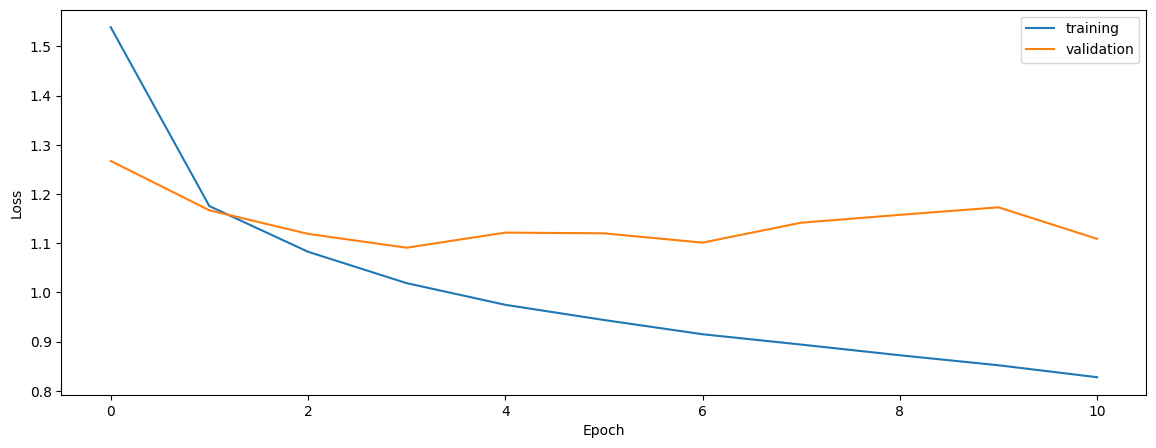

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6175450911824687
0.5652760945250441
0.585429476913653


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.5274798931926054
0.5103540263869591


0.48312513387988987


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.528054189096019
0.5050990768007485
0.48345604586148605


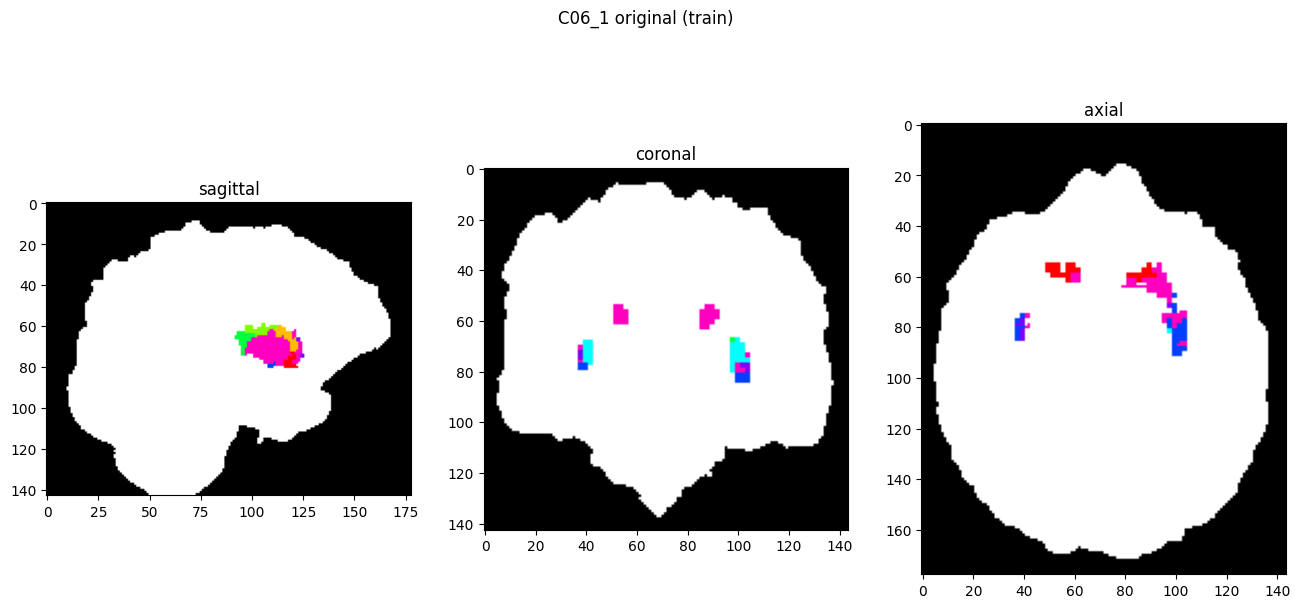

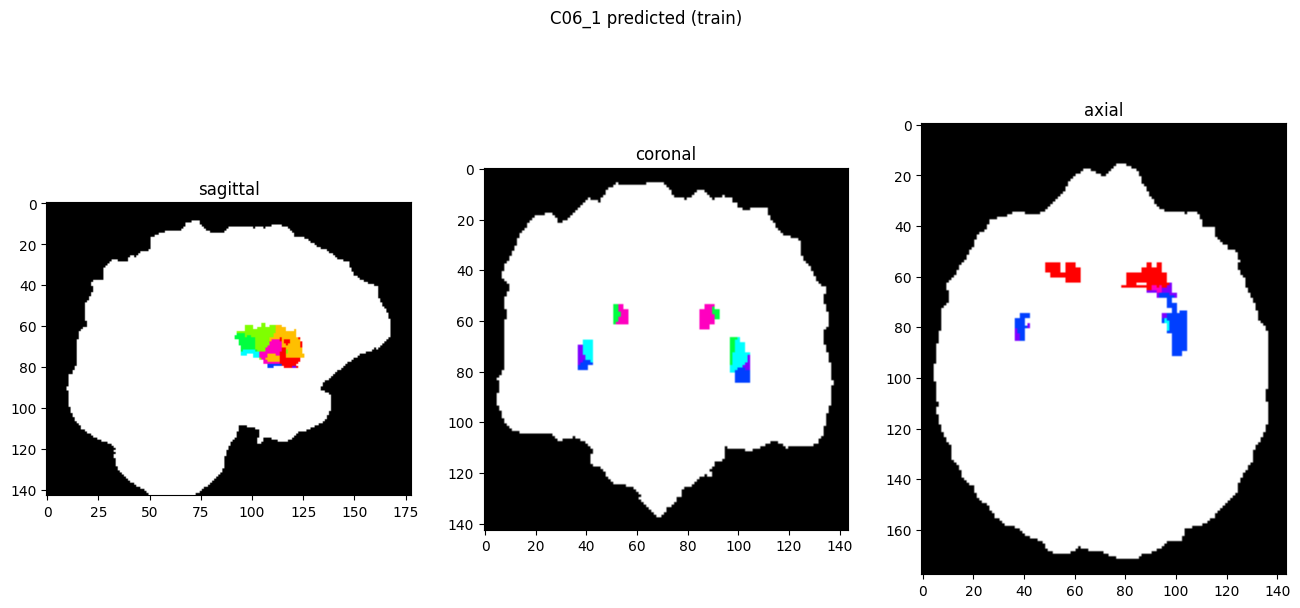

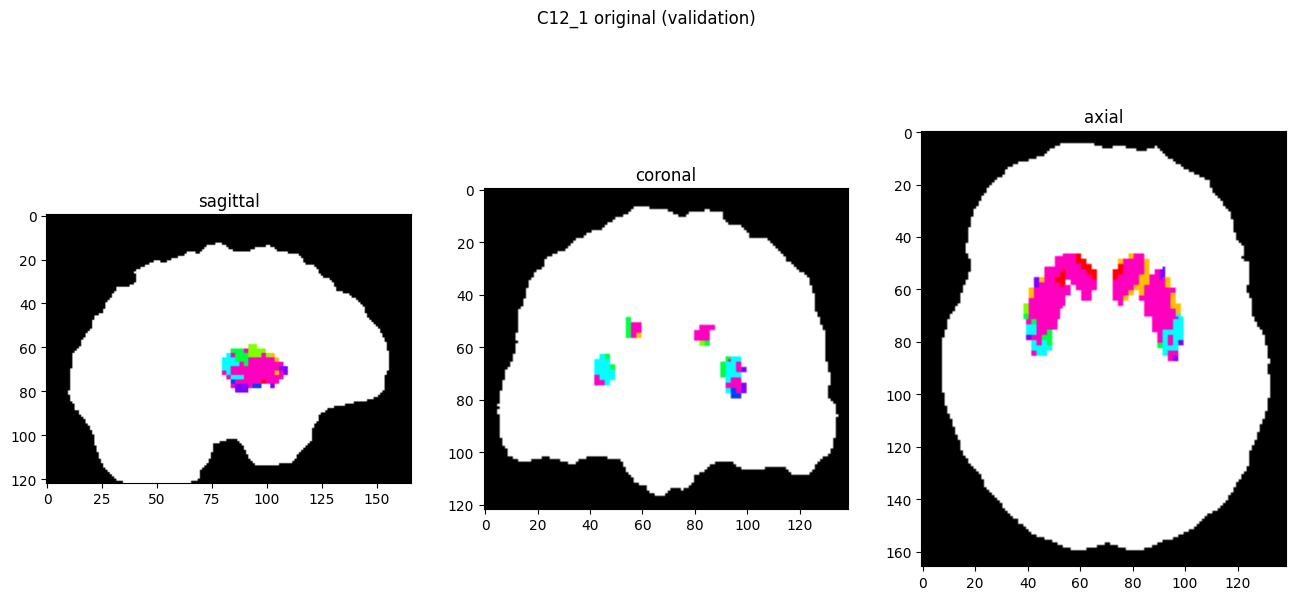

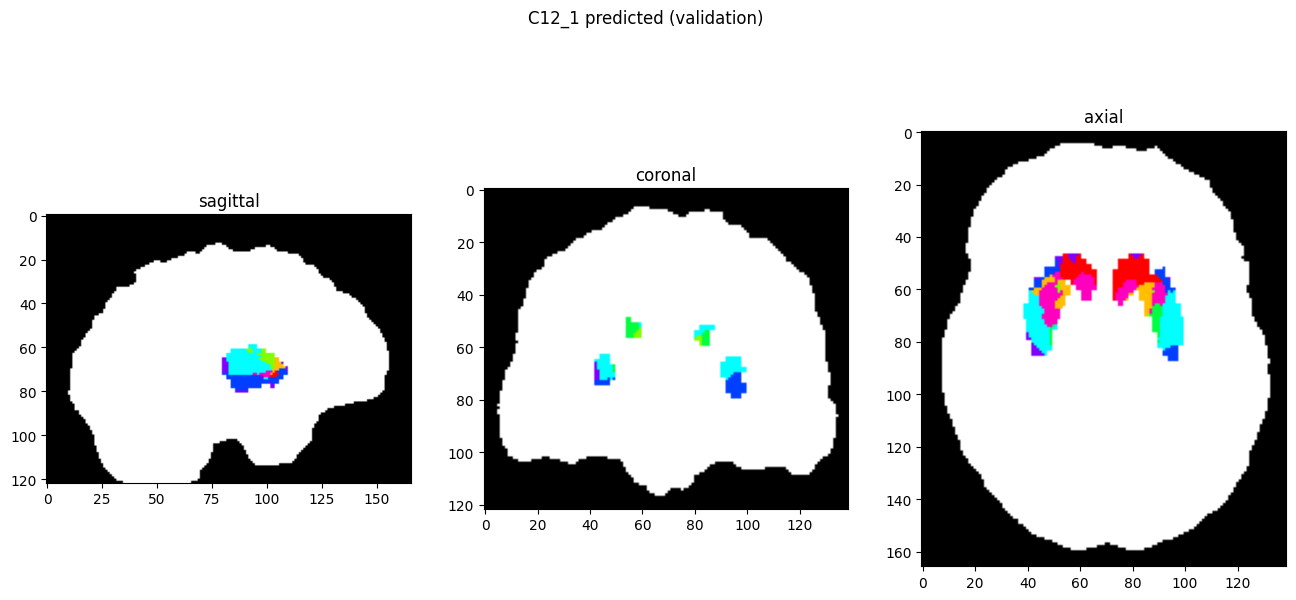

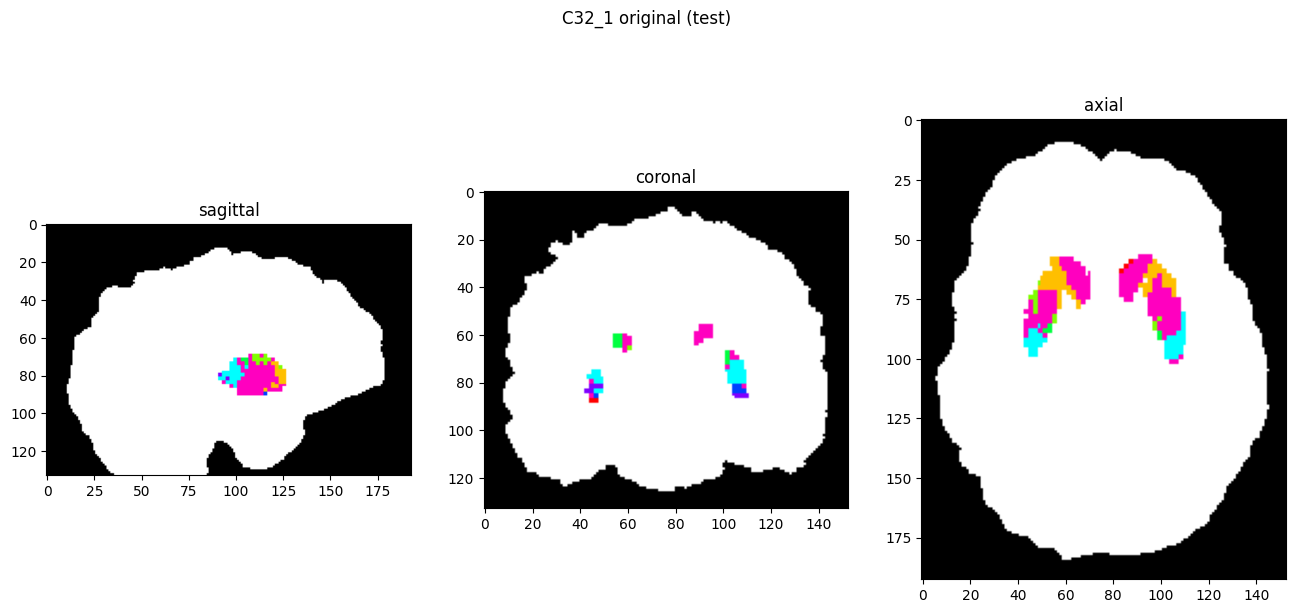

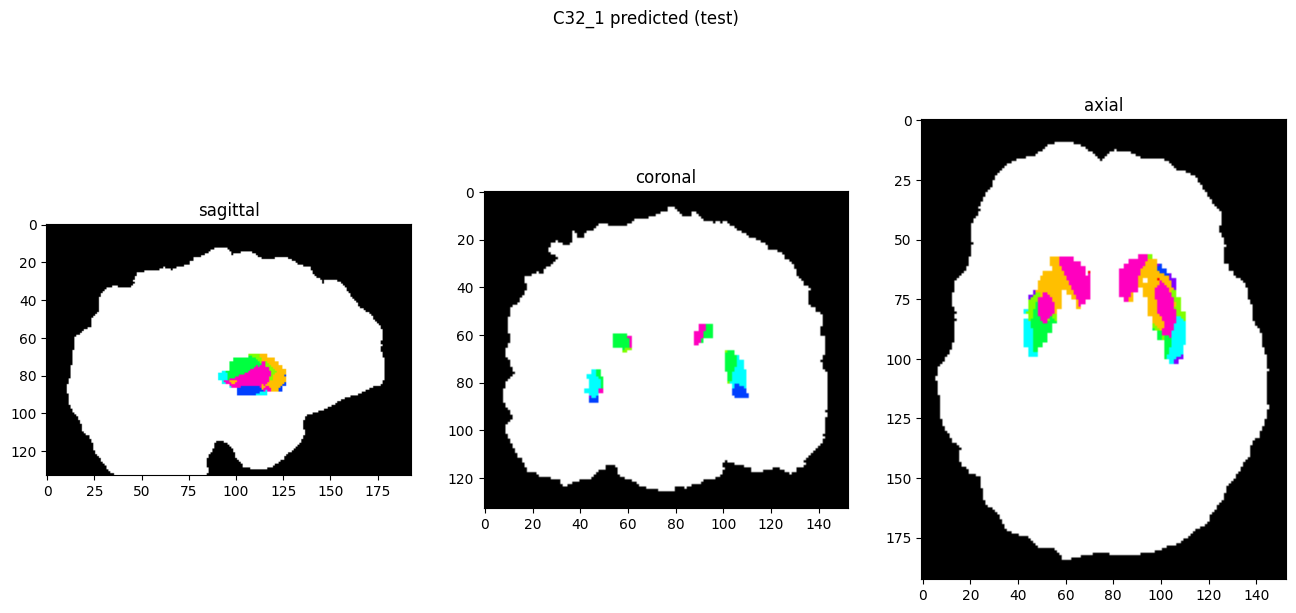

In [10]:
showResults(model, gen, threshold=0)